In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import constants as C

In [2]:
time_list = [
    5, 10, 15, 20, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 55,
    60, 65, 70, 75, 80, 85, 90, 95, 100
    ]

In [3]:
ds_array = []

for ii in range(10):
    ds_array = np.append( ds_array, 
                         yt.TipsyDataset('run694v2.0'+'%02d'%(ii+1)+'00', dataset_type='tipsy', 
                                         unit_base = {"mass":(2.33e5, "Msun")}) )

yt : [INFO     ] 2019-06-25 16:54:04,969 Parameters: current_time              = 1.0000000000000007
yt : [INFO     ] 2019-06-25 16:54:04,970 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-06-25 16:54:04,972 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-06-25 16:54:04,973 Parameters: domain_right_edge         = None
yt : [INFO     ] 2019-06-25 16:54:04,973 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-06-25 16:54:05,248 Allocating for 2.616e+06 particles (index particle type 'all')
yt : [INFO     ] 2019-06-25 16:54:05,493 Adding 2.616e+06 particles
yt : [INFO     ] 2019-06-25 16:54:05,852 Identified 1.593e+05 octs
yt : [INFO     ] 2019-06-25 16:54:07,223 Parameters: current_time              = 2.0000000000000013
yt : [INFO     ] 2019-06-25 16:54:07,224 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-06-25 16:54:07,227 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-06-25 16:54:07,230

In [195]:
ds = ds_array[0]
((ds.sphere(center_array[0], (5, 'kpc')))['Stars','Mass']).in_units('Msun').sum()
((ds.sphere(center_array[0], (5, 'kpc')))['Stars','Mass']).in_units('Msun').sum()/((ds.all_data()['Stars','Mass']).sum().in_units('Msun') - ((ds.sphere(center_array[0], (5, 'kpc')))['Stars','Mass']).in_units('Msun').sum())

0.33559352452639907 dimensionless

In [4]:
ds = ds_array[-1]

In [5]:
# Which stars are from dwarf
index_dwarf_prime  = np.zeros((3,len(ds_array[-1].all_data()['Stars', 'Mass'])), bool)
center_array       = [[35., 0., 143.], [-35., 0.0, -5/8*25], [45., 2., 6.]]
for ii in range(len(center_array)):
    centerDwarf  = yt.YTArray(center_array[ii], 'kpc')
    sphDwarf     = ds_array[ii].sphere(centerDwarf, (10, 'kpc')) 
    centerDwarf  = sphDwarf.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    center_array[ii] = centerDwarf
    sphDwarf     = ds_array[ii].sphere(centerDwarf, (10, 'kpc')) 
    index_dwarf_prime[ii] = np.append(np.isin(ds_array[ii].all_data()['Stars', 'iord'], sphDwarf['Stars', 'iord']),
                                      np.zeros(len(ds_array[-1].all_data()['Stars', 'iord'])-len(ds_array[ii].all_data()['Stars', 'iord']), bool))

index_dwarf = index_dwarf_prime[0] | index_dwarf_prime[1] | index_dwarf_prime[2]
del index_dwarf_prime

In [6]:
# Which stars are from host
index_host_prime = np.zeros((3,len(ds_array[-1].all_data()['Stars', 'Mass'])), bool)
for ii in range(len(center_array)):
    density = ds_array[ii].all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds_array[ii].all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds_array[ii].sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds_array[ii].sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds_array[ii].sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
    disHost    = ds_array[ii].disk(centerHost, norm_host, (50, "kpc"), (10, "kpc"))
    index_host_prime[ii] = np.append(np.isin(ds_array[ii].all_data()['Stars', 'iord'], disHost['Stars', 'iord']),
                                      np.zeros(len(ds_array[-1].all_data()['Stars', 'iord'])-len(ds_array[ii].all_data()['Stars', 'iord']), bool))

index_host = index_host_prime[0] | index_host_prime[1] | index_host_prime[2]
del index_host_prime

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)


In [13]:
# Which stars form later
index_sf = ds_array[-1].all_data()['Stars','FormationTime'] > ds_array[3].current_time

In [8]:
def Stars_from_dwarf(pfilter, data):
    filter = index_dwarf_i
    return filter 

yt.add_particle_filter("Stars_from_dwarf", function=Stars_from_dwarf,
                       filtered_type='Stars', requires=["particle_ones"])


def Stars_from_host(pfilter, data):
    Filter = index_host_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_from_host", function=Stars_from_host,
                       filtered_type='Stars', requires=["particle_ones"])


def Stars_during_merger(pfilter, data):
    Filter = index_sf_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_during_merger", function=Stars_during_merger,
                       filtered_type='Stars', requires=["particle_ones"])

def Stars_on_disk(pfilter, data):
    Filter = index_theta_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_on_disk", function=Stars_on_disk,
                       filtered_type='Stars', requires=["particle_ones"])

In [16]:
ds.derived_field_list

[('DarkMatter', ''),
 ('DarkMatter', 'Coordinates'),
 ('DarkMatter', 'Epsilon'),
 ('DarkMatter', 'FeMassFrac'),
 ('DarkMatter', 'Fe_fraction'),
 ('DarkMatter', 'HI'),
 ('DarkMatter', 'H_fraction'),
 ('DarkMatter', 'HeI'),
 ('DarkMatter', 'HeII'),
 ('DarkMatter', 'He_fraction'),
 ('DarkMatter', 'He_p2_fraction'),
 ('DarkMatter', 'Mass'),
 ('DarkMatter', 'O_fraction'),
 ('DarkMatter', 'OxMassFrac'),
 ('DarkMatter', 'Phi'),
 ('DarkMatter', 'Velocities'),
 ('DarkMatter', 'coolontime'),
 ('DarkMatter', 'igasorder'),
 ('DarkMatter', 'iord'),
 ('DarkMatter', 'massform'),
 ('DarkMatter', 'mesh_id'),
 ('DarkMatter', 'particle_angular_momentum'),
 ('DarkMatter', 'particle_angular_momentum_magnitude'),
 ('DarkMatter', 'particle_angular_momentum_x'),
 ('DarkMatter', 'particle_angular_momentum_y'),
 ('DarkMatter', 'particle_angular_momentum_z'),
 ('DarkMatter', 'particle_cylindrical_velocity_theta'),
 ('DarkMatter', 'particle_cylindrical_velocity_z'),
 ('DarkMatter', 'particle_mass'),
 ('DarkMatter

In [9]:
def Profile_synthesis( Radius, Mass, FormationTime, n_bins):
    rr      = Radius.in_cgs()
    yy      = Mass.in_cgs()
    zz      = (ds.current_time - FormationTime).in_cgs()
    raxis   = yt.YTArray(np.zeros(n_bins), rr.units)
    yaxis   = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    yerror  = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    zaxis   = yt.YTArray(np.zeros(n_bins), zz.units)
    rstep   = r_3.in_cgs() / n_bins
        
    for jj in range(n_bins):# total mass profile
        booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
        raxis[jj]  = jj * rstep
        yaxis[jj]  = ( yy[booleanr] ).sum() / (C.pi*(2*jj+1)*rstep**2)
        yerror[jj] = ( yy[booleanr] ).std(ddof=1) / (C.pi*(2*jj+1)*rstep**2)
        zaxis[jj]  = ( (zz*yy)[booleanr] ).sum() / yy[booleanr].sum()
        
    
    return([raxis, yaxis, zaxis, yerror])

def Profile_dispersion( Radius, Mass, Velocity, n_bins):
    rr      = Radius.in_cgs()
    #yy      = Mass.in_cgs()
    zz      = Velocity.in_cgs()
    raxis   = yt.YTArray(np.zeros(n_bins), rr.units)
    #yaxis   = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    #yerror  = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    zaxis   = yt.YTArray(np.zeros(n_bins), zz.units)
    rstep   = r_3.in_cgs() / n_bins
        
    for jj in range(n_bins):# total mass profile
        booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
        raxis[jj]  = jj * rstep
        #yaxis[jj]  = ( yy[booleanr] ).sum() / (C.pi*(2*jj+1)*rstep**2)
        #yerror[jj] = ( yy[booleanr] ).std(ddof=1) / (C.pi*(2*jj+1)*rstep**2)
        zaxis[jj]  = zz[booleanr].std()#( (zz*yy)[booleanr] ).sum() / yy[booleanr].sum()
        
    
    return([raxis, zaxis])

def Profile_average( Radius, Mass, Param, Rrange, n_bins ):
    rr = Radius.in_cgs()
    yy = Mass.in_cgs()
    zz = Param.in_cgs()
    if len(np.shape(zz))==1: # if the Param is a scalar array
        raxis = yt.YTArray(np.zeros(n_bins), rr.units)
        zaxis = yt.YTArray(np.zeros(n_bins), zz.units)
        zerr  = yt.YTArray(np.zeros(n_bins), zz.units)
        rstep = Rrange.in_cgs() / n_bins

        for jj in range(n_bins):
            booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
            raxis[jj]  = jj * rstep
            zaxis[jj]  = (zz[booleanr]*yy[booleanr]).sum() / (yy[booleanr].sum())
            zerr_temp  = (zz[booleanr]*yy[booleanr]) / (yy[booleanr].mean())
            if len(zerr_temp)>0:
                zerr[jj]   = zerr_temp[(zerr_temp>=np.percentile(zerr_temp,5)) \
                                       & (zerr_temp<=np.percentile(zerr_temp,95))].std()

        return ([raxis, zaxis, zerr])
    
    else: # if the Param is a vetor array
        yy    = Mass.in_cgs().repeat(np.shape(zz)[-1]).reshape(-1,np.shape(zz)[-1])
        raxis = yt.YTArray(np.zeros( n_bins), rr.units)
        zaxis = yt.YTArray(np.zeros((n_bins, np.shape(zz)[-1])), zz.units)
        zerr  = yt.YTArray(np.zeros((n_bins, np.shape(zz)[-1])), zz.units)
        rstep = Rrange.in_cgs() / n_bins

        for jj in range(n_bins):
            booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
            raxis[jj]  = jj * rstep
            zaxis[jj]  = (zz[booleanr]*yy[booleanr]).sum(axis=0) / (yy[booleanr].sum(axis=0))
            zerr_temp  = (zz[booleanr]*yy[booleanr]) / (yy[booleanr].mean(axis=0))
            zerr_elem  = []
            if len(zerr_temp)>0:
                for kk in range(np.shape(zz)[-1]):
                    bboolean = (zerr_temp[:,kk]>=np.percentile(zerr_temp[:,kk],5)) \
                        & (zerr_temp[:,kk]<=np.percentile(zerr_temp[:,kk],95))
                    zerr_elem.append( zerr_temp[:,kk][bboolean].base.std() )
                zerr[jj]   = yt.YTArray( zerr_elem, zerr_temp.units )

        return ([raxis, zaxis, zerr])

In [10]:
from astropy.table import Table
cata = Table.read('fits/694_06_0.txt', format='ascii')
ell = cata['col7'].copy()
ell[ell=='INDEF'] = np.nan
ell = ell.astype('float')
resolve = 0.1 * yt.units.kpc
r_3 = cata['col2'][np.where(np.gradient(ell)==np.gradient(ell)[~np.isnan(np.gradient(ell))].min())][0]*resolve
del cata, ell

In [11]:
t_height = 4 * yt.units.kpc 
bins = 50
r_break = np.zeros(10)
oiratio = np.zeros(10)

In [12]:
with open('r_break.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    r_break[nn] = float(aa[nn].replace('\n', ''))
    
with open('oiratio.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    oiratio[nn] = float(aa[nn].replace('\n', ''))

In [13]:
ii = 9
ds = ds_array[ii]

In [14]:
density = ds.all_data()[('Gas', 'Density')]
target  = np.where(density == density.max())[0][0]
del density
centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
#计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)


In [15]:
index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]#

if ii == 0:
    index_host_i  = index_host_i  * False
    index_dwarf_i = index_dwarf_i * False

ds.add_particle_filter('Stars_from_dwarf')
ds.add_particle_filter('Stars_from_host')
ds.add_particle_filter('Stars_during_merger')
#del index_dwarf_i, index_host_i, index_sf_i

True

In [16]:
host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                  Mass=host_galaxy['Stars','Mass'],
                                                    FormationTime=host_galaxy['Stars','FormationTime'],
                                                  n_bins=bins )
xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                  n_bins=bins )
xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                  n_bins=bins )
xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                  n_bins=bins )

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


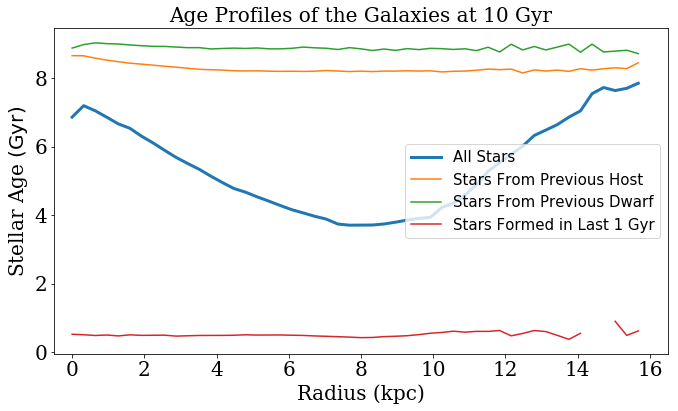

In [17]:
fig, axes1 = plt.subplots(figsize=(11,6))

plt.plot(xaxis.in_units('kpc'), pro_age_all.in_units('Gyr'), label='All Stars', linewidth=3)
plt.plot(xaxis.in_units('kpc'), pro_age_hos.in_units('Gyr'), label='Stars From Previous Host')
plt.plot(xaxis.in_units('kpc'), pro_age_dwa.in_units('Gyr'), label='Stars From Previous Dwarf')
plt.plot(xaxis.in_units('kpc'), pro_age_kid.in_units('Gyr'), label='Stars Formed in Last 1 Gyr')

#plt.yscale('log')
plt.ylabel(r'Stellar Age $(\mathrm{Gyr})$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
#plt.annotate('$r_{break}$', xy =( float(r_2)-4.5, 1e3), fontsize=18 )
plt.xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
plt.vlines(x=r_break[ii], ymin=0, ymax=ii+1, color='#3182bd',linestyle="--")
plt.title('Age Profiles of the Galaxies at %d'%(ii+1)+' Gyr', fontsize=20, family='serif');
plt.legend(fontsize=15);
plt.savefig('figs/ages/694_%02d'%(ii+1)+'_age_profiles.png',dpi=400,bbox_inches='tight')
plt.show()

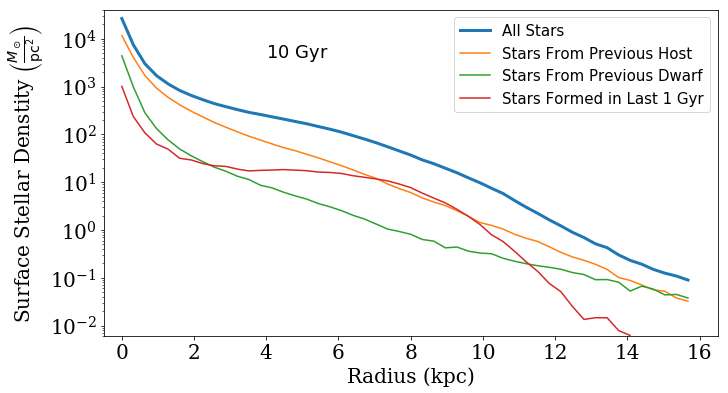

In [18]:
fig, axes2 = plt.subplots(figsize=(11,6))

plt.plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
plt.plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
plt.plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
plt.plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed in Last 1 Gyr')

#plt.plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
#plt.plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.annotate('$%2d$'%(ii+1)+' Gyr', xy =( 4, 4e3), fontsize=18 )
plt.xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
plt.ylim([6e-3,4e4])
#plt.title('Density Profiles of the Galaxy at %d'%(ii+1)+' Gyr', fontsize=20, family='serif');
plt.legend(fontsize=15);
plt.savefig('figs/694_%02d'%(ii+1)+'_den_profiles.png',dpi=400,bbox_inches='tight')
plt.show()

In [123]:
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def I_fit(r,S,alpha,beta,gamma,r_b):
    return  np.log10(S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) )

def I_show(r,param_set):
    S,alpha,beta,gamma,r_b = param_set.tolist()
    return  S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) 

r_disc    = np.array( xaxis.in_units('kpc') )
dens_disc = np.array( pro_den_all.in_units('Msun/pc**2') )
err_disc  = (np.fabs( err_den_all.in_units('Msun/pc**2') * \
                    1/np.log10(dens_disc)/np.log(10)) ).base

smoothed_den = convolve(np.log10(dens_disc), Box1DKernel(2))
grad = np.gradient(np.gradient(smoothed_den))
grad = grad[(~np.isnan(grad)) & (~np.isinf(grad))]
for i in range(0,20):
    grad=grad[np.fabs(grad-grad.mean())<=3*np.std(grad,ddof=1)]
    #更新一维数组
    #迭代20次,输出是检查循环的进行 
sigma_profile = grad.std(ddof=1) * 1
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    if np.fabs(np.gradient(np.gradient(smoothed_den)))[i]<=(sigma_profile) and\
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+1]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+2]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+3]<=(sigma_profile):
        break
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(9):
        if np.fabs(np.gradient(np.gradient(smoothed_den)))[i+j]>(sigma_profile):
            break
    if j >= 7:
        break

r_in = np.array(xaxis[i].in_units('kpc'))
r_in = res_robust.x[4]#param_set[4]
print(r_in)

for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(5):
        if (np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]>(sigma_profile))\
            | np.isinf(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]) \
            | np.isnan(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]):
            break
    if j >= 1:
        break

r_out = np.array(xaxis[-1-i].in_units('kpc'))

for i in range(len(np.gradient(np.gradient(smoothed_den)))-1):
    if (i<len(smoothed_den)-1) & (dens_disc[i] < dens_disc[i+1]) & (r_disc[i]>r_in):
        break
r_out = np.min([r_out, r_disc[i]])

#r_out = 16#13.5#r_disc[dens_disc > 4e-2][-1]
print(r_out)


param_set, param_cov = curve_fit(I_fit, xdata = r_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 ydata = np.log10(dens_disc)[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 #sigma = err_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 bounds=([0,0.1,0,0,r_in], [np.inf,1,np.inf,np.inf,r_out]),
                                p0=[1,0.5,1,1,0.5*(min(r_disc)+max(r_disc))],maxfev = 1000000)

if (param_set[2]/param_set[3] > 1.1) or (param_set[2]/param_set[3] < 1/1.1) and (r_in+0.5<=param_set[4]):
    r_break[ii] = param_set[4]
else:
    r_break[ii] = np.nan
oiratio[ii] = param_set[2]/param_set[3]
print(param_set)

6.488534701513819
14.719999999999999
[3.27578915e+04 1.00000000e+00 1.53028220e+00 1.11277574e+00
 1.16528594e+01]


In [ ]:
def I_rob(param_set, r, y):
    S, alpha, beta, gamma, r_b = param_set.tolist()

    return np.log10(S * np.exp(-1 * r / gamma) *
                    (1 + np.exp(alpha *
                                (r - r_b)))**(1 / alpha *
                                              (1 / gamma - 1 / beta))) - y


res_robust = least_squares(
    I_rob,
    x0 = param_set,
    bounds=([0,0,0,0,r_in], [np.inf,np.inf,np.inf,np.inf,r_out]),
    loss='soft_l1',
    f_scale=0.2,
    args=(r_disc[(r_disc >= r_in) & (r_disc <= r_out) & (dens_disc != 0)],
          np.log10(dens_disc)[(r_disc >= r_in) & (r_disc <= r_out) &
                              (dens_disc != 0)]))
if res_robust.success == True:
    r_break[ii] = (res_robust.x)[4]
    oiratio[ii] = (res_robust.x)[2] / (res_robust.x)[3]
else:
    r_break[ii] = np.nan
    oiratio[ii] = np.nan
res_robust.x, res_robust.success, oiratio[ii]

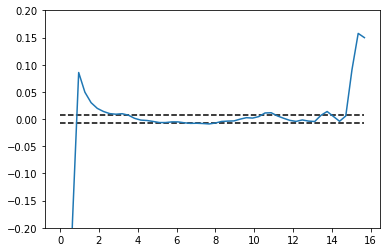

In [125]:
plt.plot(r_disc, np.gradient(np.gradient(smoothed_den)))
plt.hlines( sigma_profile, xmin=0, xmax=r_disc.max(), linestyles='dashed')
plt.hlines(-sigma_profile, xmin=0, xmax=r_disc.max(), linestyles='dashed')
plt.ylim([-0.2,0.2]);

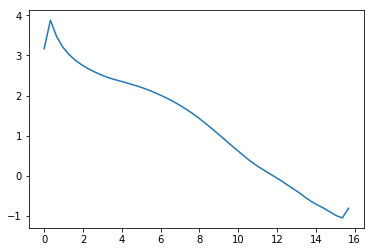

In [126]:
plt.plot(r_disc, (smoothed_den))

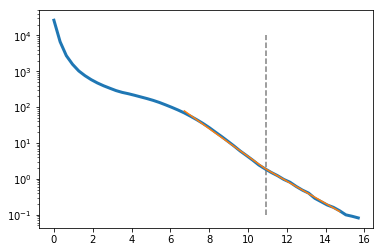

In [127]:
plt.plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), linewidth=3)
plt.plot(r_disc[(r_disc>=r_in)&(r_disc<=r_out)], I_show(np.array(r_disc[(r_disc>=r_in)&(r_disc<=r_out)]),res_robust.x) )
plt.vlines(r_break[ii], ymin=1e-1, ymax=1e4, linestyles='dashed', alpha=0.5)
plt.yscale('log');

In [288]:
with open("r_break.txt","w") as f:
    for item in r_break.astype('str'):
        f.writelines(item+'\n')
f.close()

with open("oiratio.txt","w") as f:
    for item in oiratio.astype('str'):
        f.writelines(item+'\n')
f.close()

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


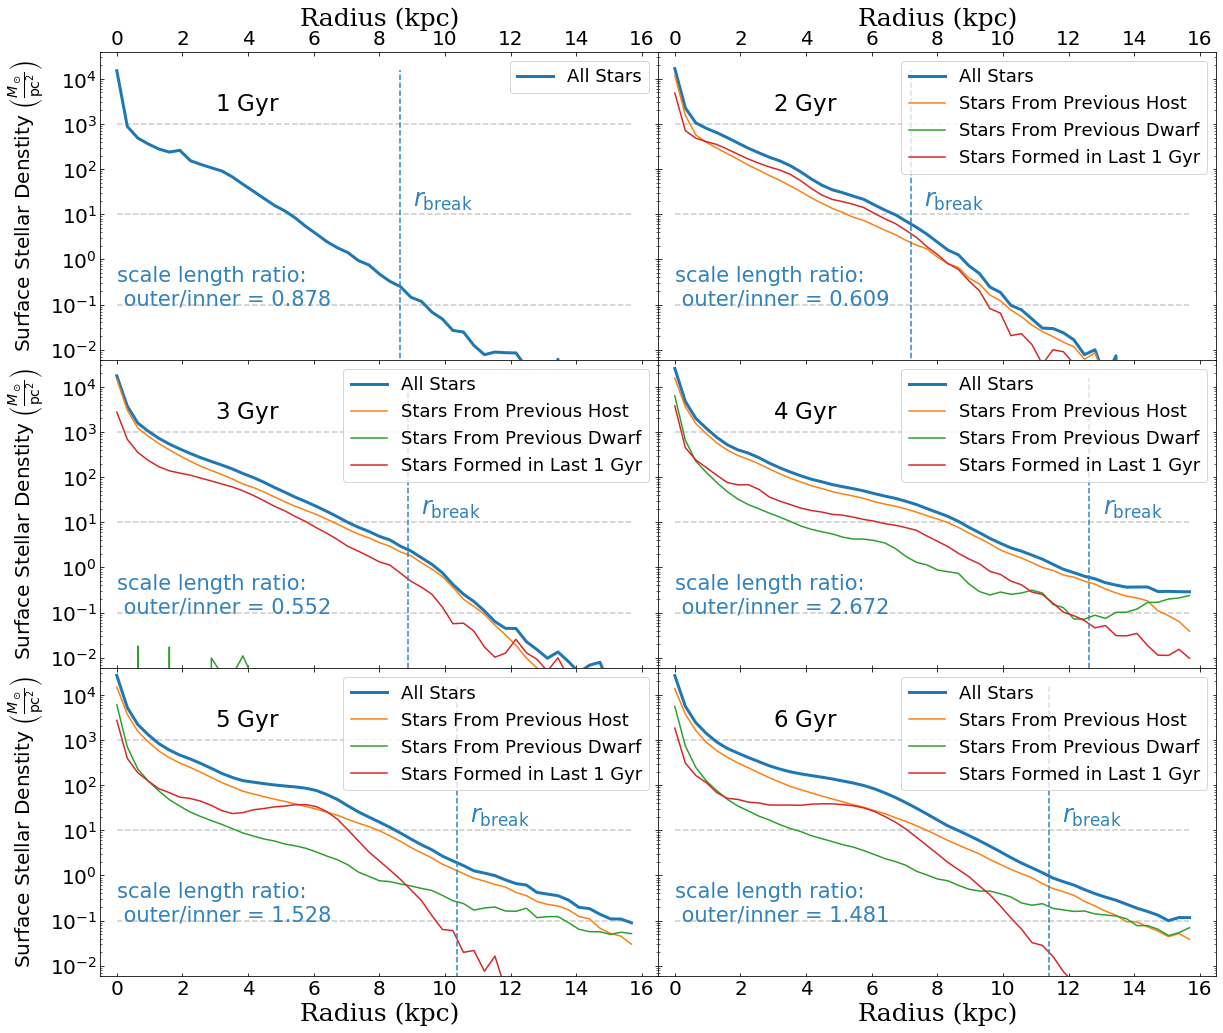

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(20, 17))

for i in range(3):
    for j in range(2):
        ds = ds_array[i*2+j]
        density = ds.all_data()[('Gas', 'Density')]
        target  = np.where(density == density.max())[0][0]
        del density
        centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
        sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
        centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
        sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

        index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[2*i+j-1].current_time)
        index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[2*i+j-1].current_time)
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[2*i+j-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]

        ds.add_particle_filter('Stars_from_dwarf')
        ds.add_particle_filter('Stars_from_host')
        ds.add_particle_filter('Stars_during_merger')

        host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
        r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

        index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
        index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
        index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

        xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                          Mass=host_galaxy['Stars','Mass'],
                                                            FormationTime=host_galaxy['Stars','FormationTime'],
                                                          n_bins=bins )
        xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                          n_bins=bins )
        
        
        axes[i, j].plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
        if ((i!=0) | (j!=0)) & (i*2+j<6):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed in Last 1 Gyr')
        if ((i!=0) | (j!=0)) & (i*2+j>5):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed After 6 Gyr')
        if ~np.isnan( r_break[i*2+j] ):
            axes[i, j].plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
            axes[i, j].annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
            axes[i, j].annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )
        axes[i ,j].hlines( y=1e3,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4)
        axes[i ,j].hlines( y=1e1,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4)
        axes[i ,j].hlines( y=1e-1, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4 )
        
        
        #axes[i, j].plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
        #axes[i, j].plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")
        axes[i, j].set_xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
        axes[i, j].set_ylim([6e-3,4e4])
        axes[i, j].set_yscale('log')
        axes[i, j].set_xlabel('Radius (kpc)', fontdict={'fontsize':25, 
                                                        'fontweight': 'ultralight',
                                                        'family':'serif'}
                                )
        #axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].set_ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
                                fontdict={'fontsize':20, 
                                'fontweight': 'ultralight'}
                                )
        #axes[i, j].set_yticklabels(axes[i, j].get_ymajorticklabels(),fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].annotate('$%d$'%(2*i+j+1)+' Gyr', xy =( 3, 2e3), fontsize=23 )
        axes[i, j].legend(fontsize=18,loc=1);
        
        axes[i, j].xaxis.set_ticks_position('both')
        if (i == 1) :
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].set_xticklabels([])
        if i == 0:
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].xaxis.set_label_position('top')
            axes[i, j].xaxis.set_ticks_position('top')
        axes[i, j].yaxis.set_ticks_position('both')
        if j == 1:
            axes[i, j].get_shared_y_axes().join(axes[i, j], axes[i, j-1])
            axes[i, j].set_yticklabels([])
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(direction='in',which='both',labelsize=20)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/multiplot_profiles.png', dpi=500, bbox_inches='tight')

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


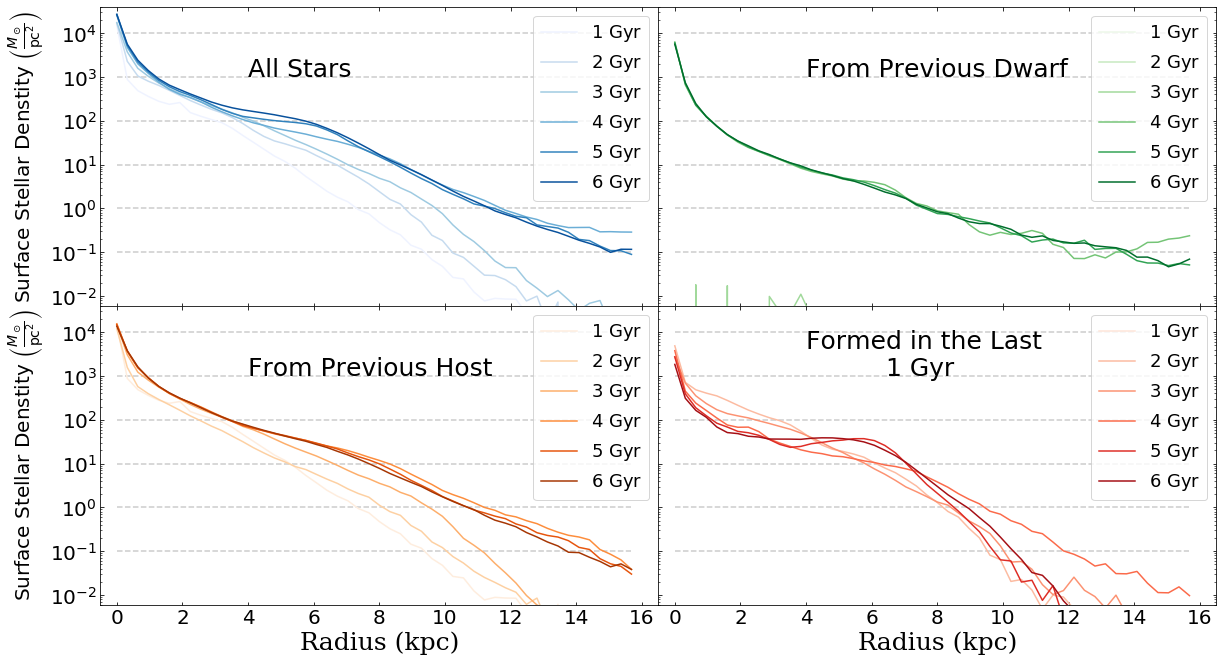

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(20, 11))

annot  = ['All Stars', 'From Previous Dwarf',
         'From Previous Host', 'Formed in the Last \n          1 Gyr'] 
colors = [['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c'],
         ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c'],
         ['#feedde','#fdd0a2','#fdae6b','#fd8d3c','#e6550d','#a63603'],
         ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']]

for i in range(6):
    ds = ds_array[i]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[i-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]

    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
    r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

    xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                      Mass=host_galaxy['Stars','Mass'],
                                                        FormationTime=host_galaxy['Stars','FormationTime'],
                                                      n_bins=bins )
    xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                      n_bins=bins )
    xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                      n_bins=bins )
    xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                      n_bins=bins )
    
    axes[0, 0].plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='$%d$'%(i+1)+' Gyr', color=colors[0][i])
    axes[0, 1].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='$%d$'%(i+1)+' Gyr', color=colors[1][i])
    axes[1, 0].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='$%d$'%(i+1)+' Gyr', color=colors[2][i])
    axes[1, 1].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='$%d$'%(i+1)+' Gyr', color=colors[3][i])
    
for j in range(2):
    for k in range(2):
        axes[j, k].hlines( y=1e4,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].hlines( y=1e3,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].hlines( y=1e2,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].hlines( y=1e1,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].hlines( y=1e0,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].hlines( y=1e-1, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(),
                          linestyle='dashed', color='grey', alpha=0.4)
        axes[j, k].set_xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
        axes[j, k].set_ylim([6e-3,4e4])
        axes[j, k].set_yscale('log')
        axes[j, k].set_xlabel('Radius (kpc)', fontdict={'fontsize':25, 
                                                        'fontweight': 'ultralight',
                                                        'family':'serif'}
                             )
        #axes[j, k].set_xticklabels(axes[i, j].get_xticklabels(), fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[j, k].set_ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
                                fontdict={'fontsize':20, 
                                'fontweight': 'ultralight'}
                             )
        #axes[j, k].set_yticklabels(axes[i, j].get_ymajorticklabels(),fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[j, k].annotate(annot[j*2+k], xy=(4, 1e3), fontsize=25 )
        #axes[j, k].title('Density Profiles of the Galaxy at %d'%(ii+1)+' Gyr', fontsize=20, family='serif');
        axes[j, k].legend(fontsize=18);

        if k == 1:
            axes[j, k].get_shared_y_axes().join(axes[j, k], axes[j, k-1])
            axes[j, k].set_yticklabels([])
            axes[j, k].set_ylabel('')
            #axes[j, k].yaxis.set_label_position('right')
            axes[j, k].yaxis.set_ticks_position('both')

        axes[j, k].xaxis.set_ticks_position('both')
        if j == 0:
            axes[j, k].get_shared_x_axes().join(axes[j, k], axes[j-1, k])
            #axes[j, k].xaxis.set_label_position('top')
            axes[j, k].set_xlabel('')
            axes[j, k].set_xticklabels([])
        axes[j, k].tick_params(direction='in', which='both', labelsize=20)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/components_profiles.png', dpi=500, bbox_inches='tight')

yt : [INFO     ] 2019-05-22 16:16:52,566 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:16:52,567 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:16:52,568 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:16:52,570 Making a fixed resolution buffer of (('deposit', 'Stars_density')) 800 by 800
yt : [INFO     ] 2019-05-22 16:17:30,532 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:17:30,533 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:17:30,533 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:17:30,534 Making a fixed resolution buffer of (('deposit', 'Stars_from_dwarf_density')) 800 by 800
yt : [INFO     ] 2019-05-22 16:18:01,821 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:18:01,822 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:18:01,822 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:18:01,823 Making a fixed resolution buffer of (('deposit', 'Stars_from_host_density')) 800 by 800
y

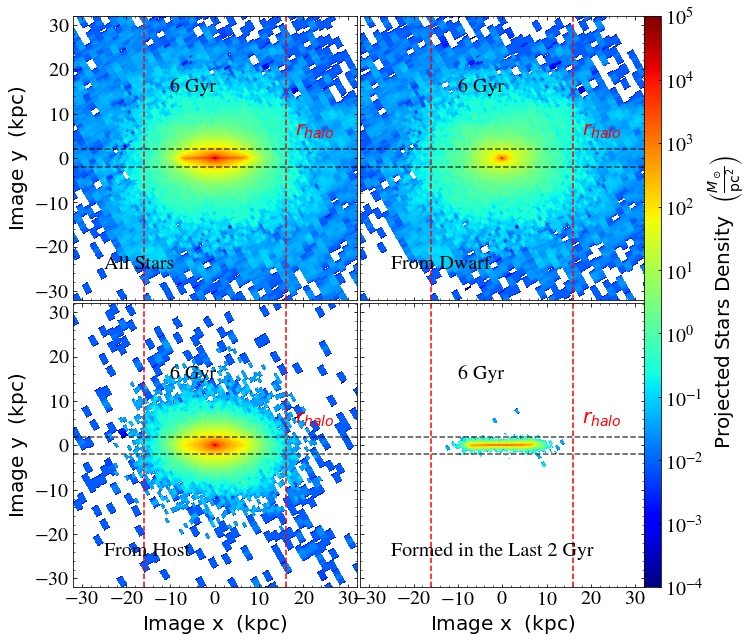

In [313]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

label = ['Stars_density', 'Stars_from_dwarf_density',
        'Stars_from_host_density', 'Stars_during_merger_density']
annot = ['All Stars', 'From Dwarf','From Host',
        'Formed in the Last 2 Gyr']
# See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# These choices of keyword arguments produce a four panel plot with a single
# shared narrow colorbar on the right hand side of the multipanel plot. Axes
# labels are drawn for all plots since we're slicing along different directions
# for each plot.
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (2, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

for jj in range(len(label)):
    pp_all_star = yt.OffAxisProjectionPlot(ds, north_host, ('deposit', label[jj]),
                                            center=centerHost, width=4*r_3, depth=4*r_3,
                                            north_vector=norm_host, method='integrate', fontsize=20)

    # Ensure the colorbar limits match for all plots
    pp_all_star.set_unit(('deposit', label[jj]), 'Msun/pc**2')
    pp_all_star.set_cmap(('deposit', label[jj]), 'jet')
    pos_of_annotate1 = yt.YTArray([-10, 15], input_units='kpc')
    pos_of_annotate2 = yt.YTArray([-25,-25], input_units='kpc')
    pos_of_annotate3 = yt.YTArray([ 18,  5], input_units='kpc')
    pp_all_star.annotate_clear()
    pp_all_star.annotate_text(pos_of_annotate1, '6 Gyr', coord_system='plot', text_args={'color':'black'})
    pp_all_star.annotate_text(pos_of_annotate2, annot[jj], coord_system='plot', text_args={'color':'black'})
    pp_all_star.annotate_line([0, 0.5 - t_height/(8*r_3)], [1, 0.5 - t_height/(8*r_3)], coord_system='axis',
                    plot_args={'color':'black', 'linestyle':'--', 'alpha':0.7})
    pp_all_star.annotate_line([0, 0.5 + t_height/(8*r_3)], [1, 0.5 + t_height/(8*r_3)], coord_system='axis',
                    plot_args={'color':'black', 'linestyle':'--', 'alpha':0.7})
    pp_all_star.annotate_text(pos_of_annotate3, '$r_{halo}$', coord_system='plot', text_args={'color':'red'})
    pp_all_star.annotate_line([0.25 , 0], [0.25, 1], coord_system='axis',
                    plot_args={'color':'red', 'linestyle':'--', 'alpha':1})
    pp_all_star.annotate_line([0.75 , 0], [0.75, 1], coord_system='axis',
                    plot_args={'color':'red', 'linestyle':'--', 'alpha':1})
    pp_all_star.set_zlim(('deposit', label[jj]), 1e-4, 1e5)

    # This forces the ProjectionPlot to redraw itself on the AxesGrid axes.
    plot = pp_all_star.plots[('deposit', label[jj])]
    plot.figure = fig
    plot.axes = grid[jj].axes
    plot.cax = grid.cbar_axes[jj]

    # Finally, this actually redraws the plot.
    pp_all_star._setup_plots()

plt.savefig('figs/multiplot_components.pdf', mpl_kwargs={'dpi':500, 'bbox_inches':'tight'});

yt : [INFO     ] 2019-05-22 16:19:08,134 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:19:08,135 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:19:08,136 zlim = -2.000000 2.000000
yt : [INFO     ] 2019-05-22 16:19:08,137 Making a fixed resolution buffer of (('deposit', 'Stars_density')) 800 by 800
yt : [INFO     ] 2019-05-22 16:19:39,692 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:19:39,693 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:19:39,694 zlim = -2.000000 2.000000
yt : [INFO     ] 2019-05-22 16:19:39,694 Making a fixed resolution buffer of (('deposit', 'Stars_from_dwarf_density')) 800 by 800
yt : [INFO     ] 2019-05-22 16:20:06,895 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:20:06,895 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-05-22 16:20:06,896 zlim = -2.000000 2.000000
yt : [INFO     ] 2019-05-22 16:20:06,897 Making a fixed resolution buffer of (('deposit', 'Stars_from_host_density')) 800 by 800
yt : [I

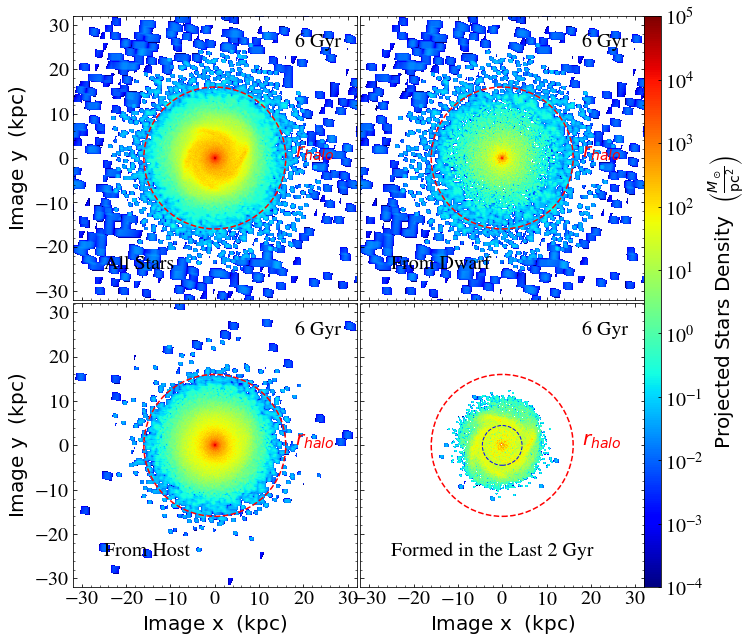

In [314]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

label = ['Stars_density', 'Stars_from_dwarf_density',
        'Stars_from_host_density', 'Stars_during_merger_density']
annot = ['All Stars', 'From Dwarf','From Host',
        'Formed in the Last 2 Gyr']
# See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# These choices of keyword arguments produce a four panel plot with a single
# shared narrow colorbar on the right hand side of the multipanel plot. Axes
# labels are drawn for all plots since we're slicing along different directions
# for each plot.
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (2, 2),
                axes_pad = 0.05,
                label_mode = "L",
                share_all = True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%")

for jj in range(len(label)):
    pp_all_star = yt.OffAxisProjectionPlot(ds, norm_host, ('deposit', label[jj]),
                                            center=centerHost, width=4*r_3, depth=t_height,
                                            north_vector=north_host, method='integrate', fontsize=20)

    # Ensure the colorbar limits match for all plots
    pp_all_star.set_unit(('deposit', label[jj]), 'Msun/pc**2')
    pp_all_star.set_cmap(('deposit', label[jj]), 'jet')
    pos_of_annotate1 = yt.YTArray([ 18, 25], input_units='kpc')
    pos_of_annotate2 = yt.YTArray([-25,-25], input_units='kpc')
    pos_of_annotate3 = yt.YTArray([ 18,  0], input_units='kpc')
    pp_all_star.annotate_clear()
    pp_all_star.annotate_text(pos_of_annotate1, '6 Gyr', coord_system='plot', text_args={'color':'black'})
    pp_all_star.annotate_text(pos_of_annotate2, annot[jj], coord_system='plot', text_args={'color':'black'})
    pp_all_star.annotate_sphere(centerHost, radius=r_3,
                          circle_args={'color':'red', 'linestyle':'--', 'linewidth':1.5})
    pp_all_star.annotate_text(pos_of_annotate3, '$r_{halo}$', coord_system='plot', text_args={'color':'red'})
    pp_all_star.set_zlim(('deposit', label[jj]), 1e-4, 1e5)
    if jj == 3:
        rmax = xaxis[pro_den_kid == pro_den_kid[xaxis>3*yt.units.kpc].max()]
        pp_all_star.annotate_sphere(centerHost, radius=rmax.in_units('kpc')[0],
                          circle_args={'color':'blue', 'linestyle':'--'})
    # This forces the ProjectionPlot to redraw itself on the AxesGrid axes.
    plot = pp_all_star.plots[('deposit', label[jj])]
    plot.figure = fig
    plot.axes = grid[jj].axes
    plot.cax = grid.cbar_axes[jj]

    # Finally, this actually redraws the plot.
    pp_all_star._setup_plots()

plt.savefig('figs/multiplot_components2.pdf', mpl_kwargs={'dpi':500, 'bbox_inches':'tight'});

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


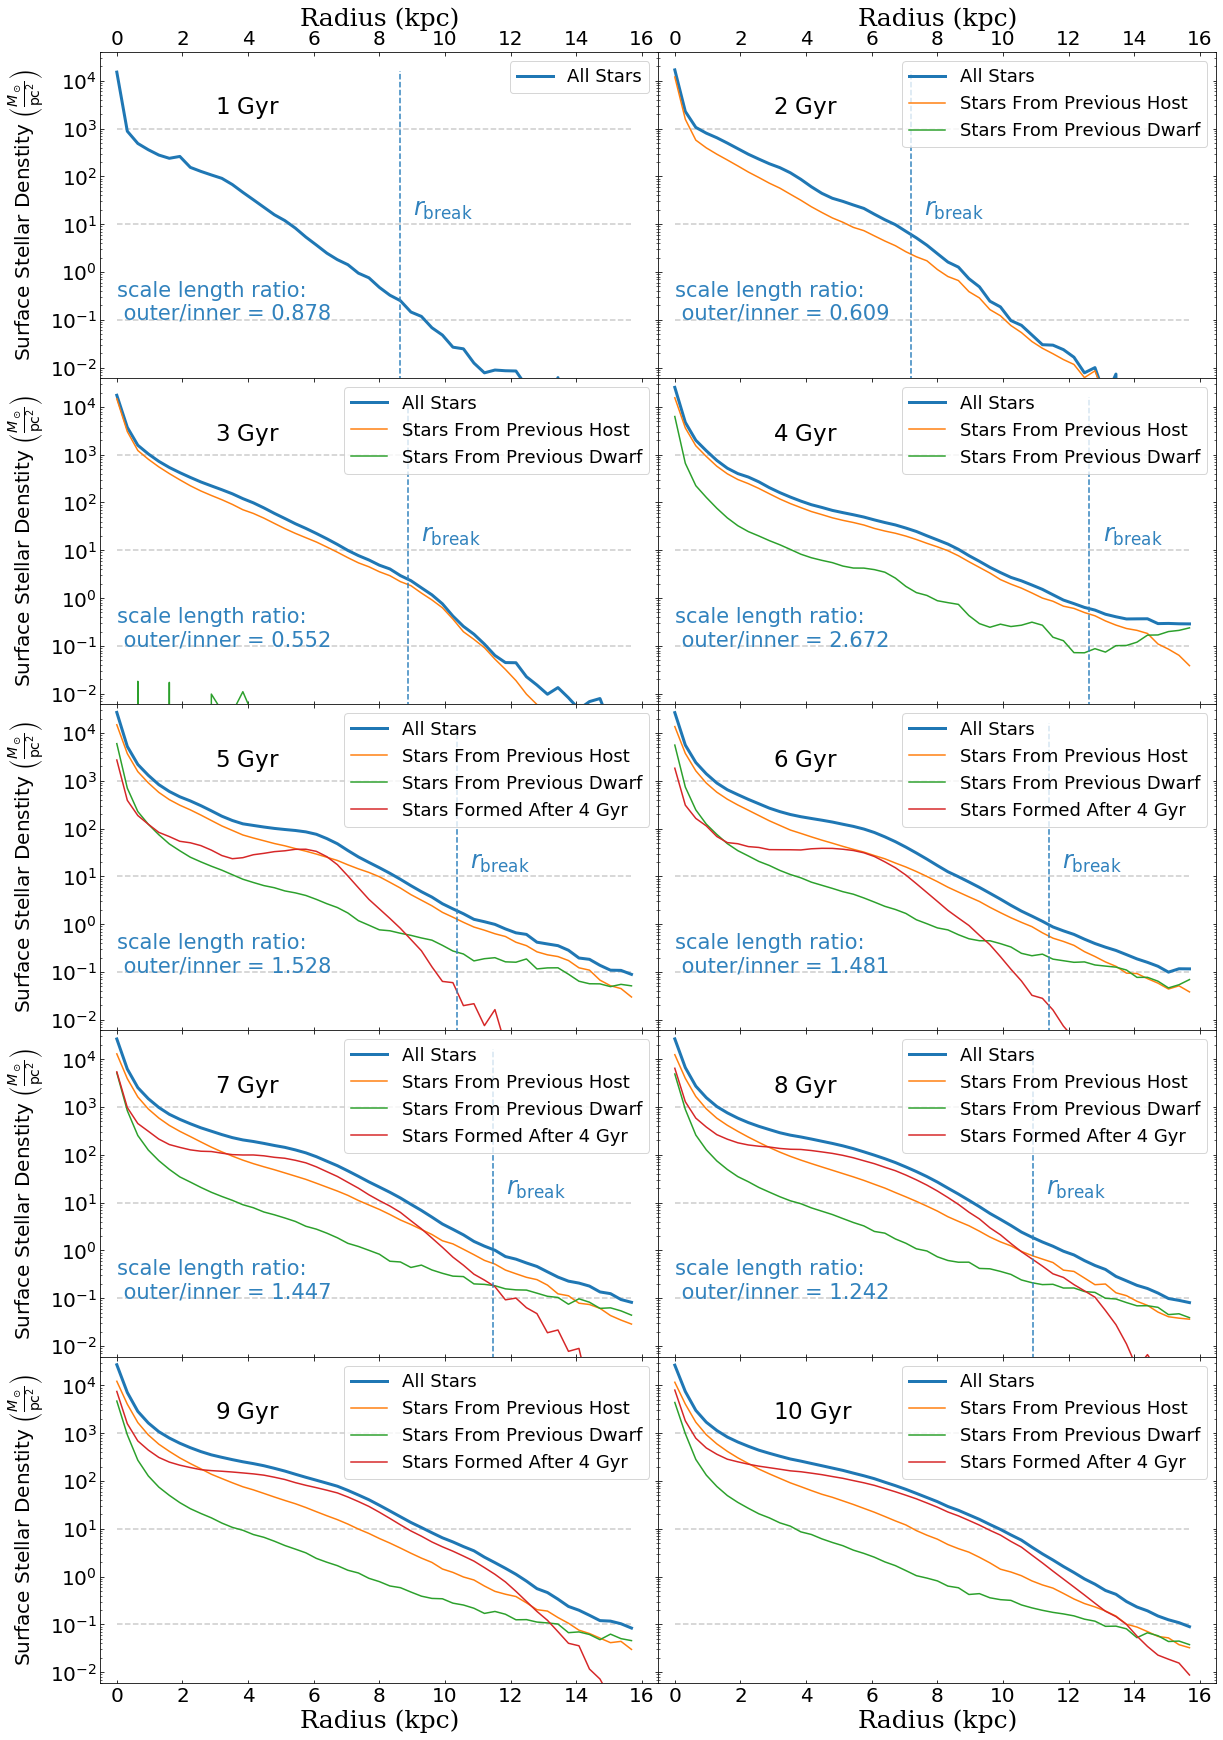

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))

for i in range(5):
    for j in range(2):
        ds = ds_array[i*2+j]
        density = ds.all_data()[('Gas', 'Density')]
        target  = np.where(density == density.max())[0][0]
        del density
        centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
        sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
        centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
        sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

        index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[2*i+j-1].current_time)
        index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[2*i+j-1].current_time)
        if 2*i+j<6:
            index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[2*i+j-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
        if 2*i+j>5:
            index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']]
        ds.add_particle_filter('Stars_from_dwarf')
        ds.add_particle_filter('Stars_from_host')
        ds.add_particle_filter('Stars_during_merger')

        host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
        r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

        index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
        index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
        index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

        xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                          Mass=host_galaxy['Stars','Mass'],
                                                            FormationTime=host_galaxy['Stars','FormationTime'],
                                                          n_bins=bins )
        xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                          n_bins=bins )
        
        
        axes[i, j].plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
        if ((i!=0) | (j!=0)) & (i*2+j<4):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
            #axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed in Last 1 Gyr')
        if ((i!=0) | (j!=0)) & (i*2+j>3):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed After 4 Gyr')#, color='#C1328E'
        if (~np.isnan( r_break[i*2+j] )) & ((i*2+j)<8):
            axes[i, j].plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
            axes[i, j].annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
            axes[i, j].annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )
        axes[i ,j].hlines( y=1e3,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4)
        axes[i ,j].hlines( y=1e1,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4)
        axes[i ,j].hlines( y=1e-1, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4 )
        
        
        #axes[i, j].plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
        #axes[i, j].plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")
        axes[i, j].set_xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
        axes[i, j].set_ylim([6e-3,4e4])
        axes[i, j].set_yscale('log')
        axes[i, j].set_xlabel('Radius (kpc)', fontdict={'fontsize':25, 
                                                        'fontweight': 'ultralight',
                                                        'family':'serif'}
                                )
        #axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].set_ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
                                fontdict={'fontsize':20, 
                                'fontweight': 'ultralight'}
                                )
        #axes[i, j].set_yticklabels(axes[i, j].get_ymajorticklabels(),fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].annotate('$%d$'%(2*i+j+1)+' Gyr', xy =( 3, 2e3), fontsize=23 )
        axes[i, j].legend(fontsize=18,loc=1);
        
        axes[i, j].xaxis.set_ticks_position('both')
        if (i == 1) or ( i == 2 ) or ( i == 3 ):
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].set_xticklabels([])
        if i == 0:
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].xaxis.set_label_position('top')
            axes[i, j].xaxis.set_ticks_position('top')
        axes[i, j].yaxis.set_ticks_position('both')
        if j == 1:
            axes[i, j].get_shared_y_axes().join(axes[i, j], axes[i, j-1])
            axes[i, j].set_yticklabels([])
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(direction='in',which='both',labelsize=20)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/multiplot_profiles2.png', dpi=500, bbox_inches='tight')

In [21]:
# velocity dispersion profile
for ii in range(10):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    if ii<6:
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>5:
        index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']]
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True)
    host_galaxy.set_field_parameter('bulk_velocity', v_b)
    
    r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

    xaxis, pro_dis_all = Profile_dispersion( Radius=r_cylindrical,
                                            Mass=host_galaxy['Stars','Mass'],
                                            Velocity=host_galaxy['Stars','particle_velocity_cylindrical_radius'],
                                            n_bins=bins )
    xaxis, pro_dis_dwa = Profile_dispersion( Radius=r_cylindrical[index_dwa_in_gala],
                                            Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                            Velocity=host_galaxy['Stars','particle_velocity_cylindrical_radius'][index_dwa_in_gala],
                                            n_bins=bins )
    xaxis, pro_dis_hos = Profile_dispersion( Radius=r_cylindrical[index_hos_in_gala],
                                            Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                            Velocity=host_galaxy['Stars','particle_velocity_cylindrical_radius'][index_hos_in_gala],
                                            n_bins=bins )
    xaxis, pro_dis_kid = Profile_dispersion( Radius=r_cylindrical[index_kid_in_gala],
                                            Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                            Velocity=host_galaxy['Stars','particle_velocity_cylindrical_radius'][index_kid_in_gala],
                                            n_bins=bins )
    
    fig = plt.figure(figsize=(11,6))
    plt.plot(xaxis.in_units('kpc'), pro_dis_all.in_units('km/s'), label='All Stars', linewidth=3)
    plt.vlines(r_break[ii], ymin=0, ymax=200, color='#3182bd', linestyle="--")
    if (ii!=0) & (ii<6):
        plt.plot(xaxis.in_units('kpc'), pro_dis_hos.in_units('km/s'), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_dis_dwa.in_units('km/s'), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_dis_kid.in_units('km/s'), label='Stars Formed in Last 1 Gyr')
    if (ii!=0) & (ii>5):
        plt.plot(xaxis.in_units('kpc'), pro_dis_hos.in_units('km/s'), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_dis_dwa.in_units('km/s'), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_dis_kid.in_units('km/s'), label='Stars Formed After 6 Gyr', color='#C1328E')
    #if ~np.isnan( r_break[i*2+j] ):
        #plt.plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
        #plt.annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
        #plt.annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )
    plt.xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
    plt.ylim([0, 223]);
    plt.ylabel(r'$\sigma_{v_r}$ $\left(\rm{km/s}\right)$',
               fontsize=20, family='serif', weight='ultralight')
    plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
    plt.xticks(fontsize=20, family='serif')
    plt.yticks(fontsize=17, family='serif')
    
    plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
    plt.legend(fontsize=15,loc=1);
    plt.savefig('figs/dispersion/%02d'%(ii+1)+'.png' );
    plt.close();

In [124]:
# metallicity profile
for ii in range(10):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    sphHost_4_norm.clear_data()
    v_b = sphHost_4_norm.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
    print(norm_host, north_host)

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    if ii<6:
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>5:
        index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']]
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height = 15*yt.units.kpc)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)
    
    r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])
    
    '''
    AM = np.cross(
    host_galaxy['Stars', 'particle_position_relative'].in_units('kpc'),
    host_galaxy['Stars', 'particle_velocity_relative'].in_units('km/s'))\
    * yt.units.km * yt.units.kpc / yt.units.s
    '''
    Metal = host_galaxy['Stars', 'Metals']
    
    nbins= 50
    xaxis, pro_met_all, err_met_all = Profile_average( Radius=r_cylindrical,
                                                 Mass=host_galaxy['Stars','Mass'],
                                                 Param=Metal,#AM[:,1],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_dwa, err_met_dwa = Profile_average( Radius=r_cylindrical[index_dwa_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                 Param=Metal[index_dwa_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_hos, err_met_hos = Profile_average( Radius=r_cylindrical[index_hos_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                 Param=Metal[index_hos_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_kid, err_met_kid = Profile_average( Radius=r_cylindrical[index_kid_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                 Param=Metal[index_kid_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    
    fig = plt.figure(figsize=(11,6))
    plt.plot(xaxis.in_units('kpc'), pro_met_all.in_cgs(), label='All Stars', linewidth=3)
    plt.fill_between(xaxis.in_units('kpc'), (pro_met_all+err_met_all).in_cgs(),
                     (pro_met_all-err_met_all).in_cgs(), alpha=0.5)
    plt.vlines(r_break[ii], ymin=0, ymax=200, color='#3182bd', linestyle="--")
    plt.hlines( y=0, xmin=0, xmax=30, linestyles='--', colors='k')
    if (ii!=0) & (ii<6):
        plt.plot(xaxis.in_units('kpc'), pro_met_hos.in_cgs(), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_met_dwa.in_cgs(), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_met_kid.in_cgs(), label='Stars Formed in Last 1 Gyr')
    if (ii!=0) & (ii>5):
        plt.plot(xaxis.in_units('kpc'), pro_met_hos.in_cgs(), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_met_dwa.in_cgs(), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_met_kid.in_cgs(), label='Stars Formed After 6 Gyr', color='#C1328E')
    #if ~np.isnan( r_break[i*2+j] ):
        #plt.plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
        #plt.annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
        #plt.annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )
    
    #plt.xlim([-0.7,30.7]);
    plt.xlim([-1,31])
    plt.ylim([-0.002, 0.042]);
    plt.ylabel(r'$Z$',
               fontsize=20, family='serif', weight='ultralight')
    plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
    plt.xticks(fontsize=20, family='serif')
    plt.yticks(fontsize=17, family='serif')
    plt.title( 'Metallicity at %d Gyr'%(ii+1), fontsize=20, family='serif', weight='ultralight' )
    #plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
    plt.legend(fontsize=15, loc=1);
    plt.savefig('figs/metal/%02d'%(ii+1)+'.png' );
    plt.close();

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)


[ 2.92464652e+26 -3.67182839e+26 -5.93777080e+28] cm**2/s [0.99998787 0.         0.00492544] kpc


/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/home/protesticon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/home/protesticon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


[ 5.74713272e+26 -3.66920191e+25 -8.09525759e+28] cm**2/s [0.9999748 0.        0.0070992] kpc
[ 2.35364955e+27 -8.16343558e+27 -8.72359014e+28] cm**2/s [0.99963623 0.         0.02697047] kpc
[ 6.93835093e+27 -2.53893197e+28 -5.81080158e+28] cm**2/s [0.99294663 0.         0.11856217] kpc
[ 1.40095044e+28 -3.50200074e+28 -6.14282577e+28] cm**2/s [0.9749661  0.         0.22235356] kpc
[ 1.47934028e+28 -4.02153352e+28 -6.83538631e+28] cm**2/s [0.97737224 0.         0.21152661] kpc
[ 1.65193686e+28 -4.47365825e+28 -7.41508634e+28] cm**2/s [0.97607152 0.         0.21744973] kpc
[ 1.91547822e+28 -4.80711969e+28 -7.80388378e+28] cm**2/s [0.97117288 0.         0.23837624] kpc
[ 1.97239458e+28 -5.00926915e+28 -8.11218898e+28] cm**2/s [0.97169072 0.         0.23625652] kpc
[ 2.17483277e+28 -5.12584938e+28 -8.37093115e+28] cm**2/s [0.96786781 0.         0.25145955] kpc


In [28]:
# angular momentum profile
component = ['x', 'y', 'z']
for ii in range(10):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    sphHost_4_norm.clear_data()
    v_b = sphHost_4_norm.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
    print(norm_host, north_host)

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    if ii<6:
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>5:
        index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']]
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height = 15*yt.units.kpc)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)

    r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])

    AM = -np.cross(
    host_galaxy['Stars', 'particle_position_relative'].in_units('kpc'),
    host_galaxy['Stars', 'particle_velocity_relative'].in_units('km/s'))\
    * yt.units.km * yt.units.kpc / yt.units.s

    nbins= 50
    xaxis, pro_AM_all, err_AM_all = Profile_average( Radius=r_cylindrical,
                                                 Mass=host_galaxy['Stars','Mass'],
                                                 Param=AM,
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_AM_dwa, err_AM_dwa = Profile_average( Radius=r_cylindrical[index_dwa_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                 Param=AM[index_dwa_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_AM_hos, err_AM_hos = Profile_average( Radius=r_cylindrical[index_hos_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                 Param=AM[index_hos_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_AM_kid, err_AM_kid = Profile_average( Radius=r_cylindrical[index_kid_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                 Param=AM[index_kid_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    
    for jj in range(np.shape(AM)[-1]):
        fig = plt.figure(figsize=(11,6))
        plt.plot(xaxis.in_units('kpc'), pro_AM_all[:,jj].in_units('km/s*kpc'), label='All Stars', linewidth=3)
        plt.fill_between(xaxis.in_units('kpc'), (pro_AM_all+err_AM_all)[:,jj].in_units('km/s*kpc'),
                         (pro_AM_all-err_AM_all)[:,jj].in_units('km/s*kpc'), alpha=0.5)
        plt.vlines(r_break[ii], ymin=-2000, ymax=2000, color='#3182bd', linestyle="--")
        plt.hlines( y=0, xmin=0, xmax=30, linestyles='--', colors='k')
        if (ii!=0) & (ii<6):
            plt.plot(xaxis.in_units('kpc'), pro_AM_hos[:,jj].in_units('km/s*kpc'), label='Stars From Previous Host')
            plt.plot(xaxis.in_units('kpc'), pro_AM_dwa[:,jj].in_units('km/s*kpc'), label='Stars From Previous Dwarf')
            plt.plot(xaxis.in_units('kpc'), pro_AM_kid[:,jj].in_units('km/s*kpc'), label='Stars Formed in Last 1 Gyr')
        if (ii!=0) & (ii>5):
            plt.plot(xaxis.in_units('kpc'), pro_AM_hos[:,jj].in_units('km/s*kpc'), label='Stars From Previous Host')
            plt.plot(xaxis.in_units('kpc'), pro_AM_dwa[:,jj].in_units('km/s*kpc'), label='Stars From Previous Dwarf')
            plt.plot(xaxis.in_units('kpc'), pro_AM_kid[:,jj].in_units('km/s*kpc'), label='Stars Formed After 6 Gyr', color='#C1328E')
        #if ~np.isnan( r_break[i*2+j] ):
            #plt.plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
            #plt.annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
            #plt.annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )

        #plt.xlim([-0.7,30.7]);
        plt.xlim([-1,31])
        plt.ylim([-2800, 2800]);
        plt.ylabel(r'$L_'+component[jj]+'$ ($\mathrm{kpc}\cdot\mathrm{km/s}$)',
                   fontsize=20, family='serif', weight='ultralight')
        plt.xlabel('Radius ($\mathrm{kpc}$)',fontsize=20, family='serif', weight='ultralight')
        plt.xticks(fontsize=20, family='serif')
        plt.yticks(fontsize=17, family='serif')
        plt.title( 'Metallicity at %d Gyr'%(ii+1), fontsize=20, family='serif', weight='ultralight' )
        #plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
        plt.legend(fontsize=15, loc=3);
        plt.savefig('figs/AM/'+component[jj]+'_%02d_'%(ii+1)+'.png' );
        plt.close();

[ 2.92464652e+26 -3.67182839e+26 -5.93777080e+28] cm**2/s [0.99998787 0.         0.00492544] kpc


/home/protesticon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice.


[ 5.74713272e+26 -3.66920191e+25 -8.09525759e+28] cm**2/s [0.9999748 0.        0.0070992] kpc
[ 2.35364955e+27 -8.16343558e+27 -8.72359014e+28] cm**2/s [0.99963623 0.         0.02697047] kpc
[ 6.93835093e+27 -2.53893197e+28 -5.81080158e+28] cm**2/s [0.99294663 0.         0.11856217] kpc
[ 1.40095044e+28 -3.50200074e+28 -6.14282577e+28] cm**2/s [0.9749661  0.         0.22235356] kpc
[ 1.47934028e+28 -4.02153352e+28 -6.83538631e+28] cm**2/s [0.97737224 0.         0.21152661] kpc
[ 1.65193686e+28 -4.47365825e+28 -7.41508634e+28] cm**2/s [0.97607152 0.         0.21744973] kpc
[ 1.91547822e+28 -4.80711969e+28 -7.80388378e+28] cm**2/s [0.97117288 0.         0.23837624] kpc
[ 1.97239458e+28 -5.00926915e+28 -8.11218898e+28] cm**2/s [0.97169072 0.         0.23625652] kpc
[ 2.17483277e+28 -5.12584938e+28 -8.37093115e+28] cm**2/s [0.96786781 0.         0.25145955] kpc


In [21]:
# velocity dispersion ratio profile
component = ['r', r'\theta', r'\phi']
for ii in range(10):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    sphHost_4_norm.clear_data()
    v_b = sphHost_4_norm.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
    print(norm_host, north_host)

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time)
    if ii<6:
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>5:
        index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']]
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.sphere(centerHost, radius=(30*yt.units.kpc))
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)
    
    r_spherical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                             + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 \
                             + (host_galaxy[('Stars', 'particle_position_relative_z')])**2 ).in_units('kpc')

    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])
    
    Velocity = (np.array([
        host_galaxy['Stars', 'particle_velocity_spherical_radius'].base,
        host_galaxy['Stars', 'particle_velocity_spherical_theta'].base,
        host_galaxy['Stars', 'particle_velocity_spherical_phi'].base
        ]) * yt.units.cm / yt.units.s).transpose()
    
    nbins= 50
    xaxis, pro_v_all, err_v_all = Profile_average( Radius=r_spherical,
                                                 Mass=host_galaxy['Stars','Mass'],
                                                 Param=Velocity,
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_v_dwa, err_v_dwa = Profile_average( Radius=r_spherical[index_dwa_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                 Param=Velocity[index_dwa_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_v_hos, err_v_hos = Profile_average( Radius=r_spherical[index_hos_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                 Param=Velocity[index_hos_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_v_kid, err_v_kid = Profile_average( Radius=r_spherical[index_kid_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                 Param=Velocity[index_kid_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    
    for jj in range(np.shape(Velocity)[-1]):
        fig = plt.figure(figsize=(11,6))
        plt.plot(xaxis.in_units('kpc'), err_v_all[:,jj]/err_v_all[:,np.mod(jj+1,3)],
                 label='All Stars', linewidth=3)
        '''
        plt.fill_between(xaxis.in_units('kpc'), (pro_met_all+err_met_all).in_cgs(),
                         (pro_met_all-err_met_all).in_cgs(), alpha=0.5)
        '''
        plt.vlines(r_break[ii], ymin=0, ymax=4.5, color='#3182bd', linestyle="--")
        plt.hlines( y=1, xmin=0, xmax=30, linestyles='--', colors='k')
        if (ii!=0) & (ii<6):
            plt.plot(xaxis.in_units('kpc'), err_v_hos[:,jj]/err_v_hos[:,np.mod(jj+1,3)], label='Stars From Previous Host')
            plt.plot(xaxis.in_units('kpc'), err_v_dwa[:,jj]/err_v_dwa[:,np.mod(jj+1,3)], label='Stars From Previous Dwarf')
            plt.plot(xaxis.in_units('kpc'), err_v_kid[:,jj]/err_v_kid[:,np.mod(jj+1,3)], label='Stars Formed in Last 1 Gyr')
        if (ii!=0) & (ii>5):
            plt.plot(xaxis.in_units('kpc'), err_v_hos[:,jj]/err_v_hos[:,np.mod(jj+1,3)], label='Stars From Previous Host')
            plt.plot(xaxis.in_units('kpc'), err_v_dwa[:,jj]/err_v_dwa[:,np.mod(jj+1,3)], label='Stars From Previous Dwarf')
            plt.plot(xaxis.in_units('kpc'), err_v_kid[:,jj]/err_v_kid[:,np.mod(jj+1,3)], label='Stars Formed After 6 Gyr', color='#C1328E')
        #if ~np.isnan( r_break[i*2+j] ):
            #plt.plot(np.ones(5)*r_break[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
            #plt.annotate('$r_\mathrm{break}$', xy =( r_break[i*2+j]+0.4, 1.5e1), fontsize=24, color='#3182bd' )
            #plt.annotate('scale length ratio: \n outer/inner = %.3f'%oiratio[i*2+j], xy =( 0, 1e-1), fontsize=21, color='#3182bd' )

        #plt.xlim([-0.7,30.7]);
        plt.xlim([-1,31])
        plt.ylim([-0.2, 5.2]);
        plt.ylabel(r'$\sigma_{v'+component[jj]+r'}/\sigma_{v'+component[np.mod(jj+1,3)]+'}$',
                   fontsize=20, family='serif', weight='ultralight')
        plt.xlabel('Spherical Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
        plt.xticks(fontsize=20, family='serif')
        plt.yticks(fontsize=17, family='serif')
        plt.title( 'Ratio of Velocity Dispersion at %d Gyr'%(ii+1),
                  fontsize=20, family='serif', weight='ultralight' )
        #plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
        plt.legend(fontsize=15, loc=1);
        plt.savefig(r'figs/sigma_sigma/%02d'%(ii+1)+'_'+str(jj)+'_'+str(np.mod(jj+1,3))+'.png' );
        plt.close();


[ 2.92464652e+26 -3.67182839e+26 -5.93777080e+28] cm**2/s [0.99998787 0.         0.00492544] kpc


/home/protesticon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice.


[ 5.74713272e+26 -3.66920191e+25 -8.09525759e+28] cm**2/s [0.9999748 0.        0.0070992] kpc
[ 2.35364955e+27 -8.16343558e+27 -8.72359014e+28] cm**2/s [0.99963623 0.         0.02697047] kpc
[ 6.93835093e+27 -2.53893197e+28 -5.81080158e+28] cm**2/s [0.99294663 0.         0.11856217] kpc
[ 1.40095044e+28 -3.50200074e+28 -6.14282577e+28] cm**2/s [0.9749661  0.         0.22235356] kpc
[ 1.47934028e+28 -4.02153352e+28 -6.83538631e+28] cm**2/s [0.97737224 0.         0.21152661] kpc
[ 1.65193686e+28 -4.47365825e+28 -7.41508634e+28] cm**2/s [0.97607152 0.         0.21744973] kpc
[ 1.91547822e+28 -4.80711969e+28 -7.80388378e+28] cm**2/s [0.97117288 0.         0.23837624] kpc
[ 1.97239458e+28 -5.00926915e+28 -8.11218898e+28] cm**2/s [0.97169072 0.         0.23625652] kpc
[ 2.17483277e+28 -5.12584938e+28 -8.37093115e+28] cm**2/s [0.96786781 0.         0.25145955] kpc


/home/protesticon/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/home/protesticon/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1032: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


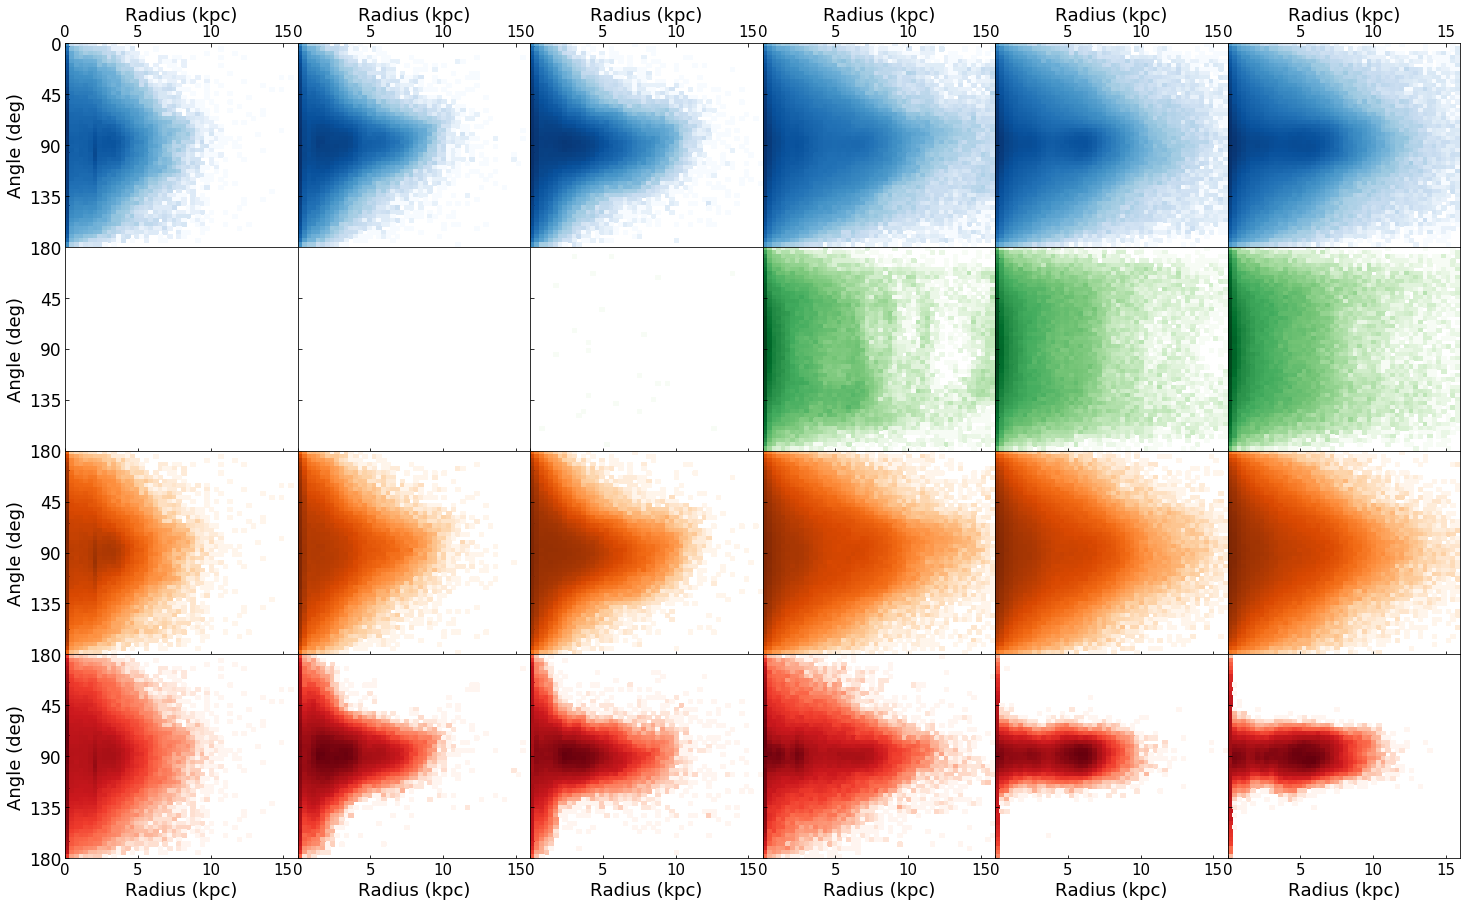

In [17]:
# angel between v and v_r
fig, axes = plt.subplots(4, 6, figsize=(25, 15))

for i in range(6):
    ds = ds_array[i]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[i-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if i==0:
        index_sf_i = index_host_i

    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=r_3, height = t_height/2)
    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
    '''
    cos = ((host_galaxy[('Stars', 'relative_particle_velocity')][:,[0,1]] * host_galaxy[('Stars', 'relative_particle_position')][:,[0,1]]).sum(axis=1)\
           / (np.linalg.norm(host_galaxy[('Stars', 'relative_particle_position')][:,[0,1]],axis=1) * np.linalg.norm(host_galaxy[('Stars', 'relative_particle_velocity')][:,[0,1]],axis=1))).base
    '''
    cos = host_galaxy['Stars', 'particle_velocity_cylindrical_radius'] \
           / (np.linalg.norm(host_galaxy['Stars', 'particle_velocity_relative'], axis=1) * yt.units.cm / yt.units.s)
    theta = np.arccos(cos) * 180 / C.pi
    
    index_all_in_gala = np.ones( len(host_galaxy['Stars','iord']), bool )
    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])
    
    index = [index_all_in_gala, index_dwa_in_gala, index_hos_in_gala, index_kid_in_gala]
    cmapl = ['Blues', 'Greens', 'Oranges', 'Reds']
    
    for j in range(4):
        axes[j, i].hist2d(r_cylindrical[index[j]], theta[index[j]], cmap=cmapl[j],
                        norm=matplotlib.colors.LogNorm(), range=[[0,r_3.base], [0, 180]], bins=50);
        axes[j, i].set_ylabel(r'Angle (deg)', fontdict={'fontsize':18, 'fontweight': 'ultralight'})
        axes[j, i].set_xlabel(r'Radius (kpc)', fontdict={'fontsize':18, 'fontweight': 'ultralight'})
        axes[j, i].set_ylim([0,180])
        axes[j, i].set_xticks([0,5,10,15])
        axes[j, i].set_xticklabels([0,5,10,15],fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[j, i].tick_params(direction='in', which='both', labelsize=15)
        axes[j, i].invert_yaxis() 
        if j == 3:
            axes[j, i].set_yticks([45,90,135,180])
            axes[j, i].set_yticklabels([45,90,135,180],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].get_shared_x_axes().join(axes[j, i], axes[j-1, i])
        if (j == 1) or (j == 2):
            axes[j, i].set_yticks([45,90,135,180])
            axes[j, i].set_yticklabels([45,90,135,180],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].get_shared_x_axes().join(axes[j, i], axes[j-1, i])
            axes[j, i].set_xticklabels([])
        if j == 0:
            axes[j, i].set_yticks([0,45,90,135,180])
            axes[j, i].set_yticklabels([0,45,90,135,180],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].xaxis.set_label_position('top')
            axes[j, i].xaxis.set_ticks_position('top')
        #axes[j, i].yaxis.set_ticks_position('both')
        if i != 0:
            axes[j, i].get_shared_y_axes().join(axes[j, i], axes[j, i-1])
            axes[j, i].set_yticklabels([])
            axes[j, i].set_ylabel('')
            
plt.subplots_adjust(wspace=0, hspace=0)

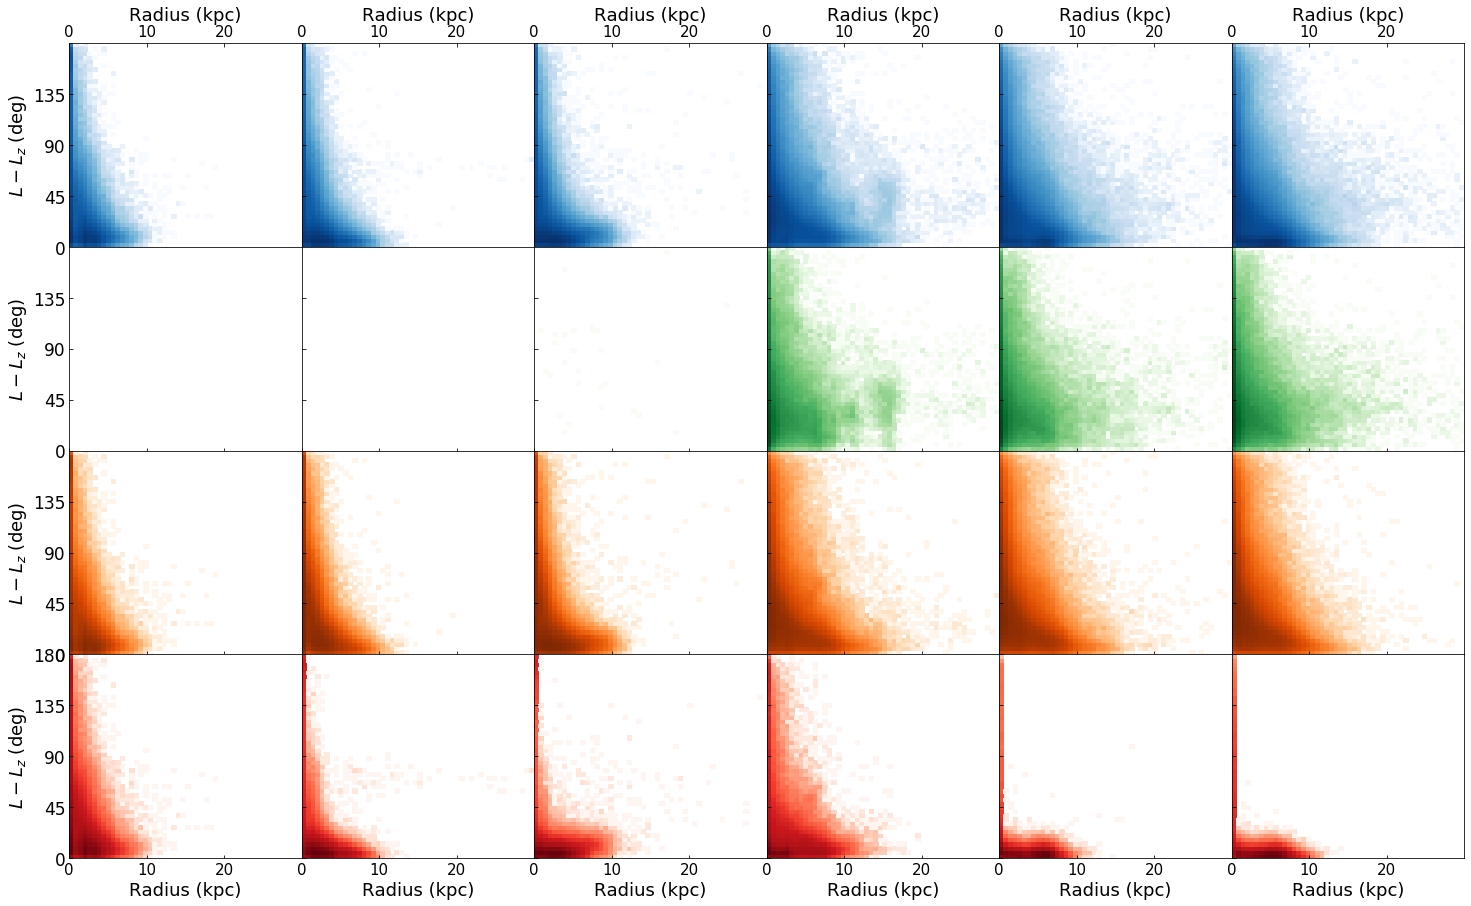

In [64]:
# theta between L and L_z
fig, axes = plt.subplots(4, 6, figsize=(25, 15))

for i in range(6):
    ds = ds_array[i]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time)
    index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[i-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if i==0:
        index_sf_i = index_host_i

    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height = t_height/2) # radius=r_3
    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
    '''
    cos = ((host_galaxy[('Stars', 'relative_particle_velocity')][:,[0,1]] * host_galaxy[('Stars', 'relative_particle_position')][:,[0,1]]).sum(axis=1)\
           / (np.linalg.norm(host_galaxy[('Stars', 'relative_particle_position')][:,[0,1]],axis=1) * np.linalg.norm(host_galaxy[('Stars', 'relative_particle_velocity')][:,[0,1]],axis=1))).base
    '''
    AM = -np.cross(
    host_galaxy['Stars', 'particle_position_relative'].in_units('kpc'),
    host_galaxy['Stars', 'particle_velocity_relative'].in_units('km/s'))\
    * yt.units.km * yt.units.kpc / yt.units.s
    
    cos = AM[:,2] / (np.linalg.norm(AM, axis=1) * yt.units.cm / yt.units.s)
    theta = np.arccos(cos) * 180 / C.pi
    
    index_all_in_gala = np.ones( len(host_galaxy['Stars','iord']), bool )
    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_during_merger', 'iord'])
    
    index = [index_all_in_gala, index_dwa_in_gala, index_hos_in_gala, index_kid_in_gala]
    cmapl = ['Blues', 'Greens', 'Oranges', 'Reds']
    
    for j in range(4):
        axes[j, i].hist2d(r_cylindrical[index[j]], theta[index[j]], cmap=cmapl[j],
                        norm=matplotlib.colors.LogNorm(), range=[[0,30*yt.units.kpc], [0, 180]], bins=50);
        axes[j, i].set_ylabel(r'$L-L_z$ (deg)', fontdict={'fontsize':18, 'fontweight': 'ultralight'})
        axes[j, i].set_xlabel(r'Radius (kpc)', fontdict={'fontsize':18, 'fontweight': 'ultralight'})
        axes[j, i].set_ylim([0,180])
        axes[j, i].set_xticks([0,10,20])
        axes[j, i].set_xticklabels([0,10,20],fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[j, i].tick_params(direction='in', which='both', labelsize=15)
        
        if j == 3:
            axes[j, i].set_yticks([0,45,90,135,180])
            axes[j, i].set_yticklabels([0,45,90,135,180],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].get_shared_x_axes().join(axes[j, i], axes[j-1, i])
        if (j == 1) or (j == 2):
            axes[j, i].set_yticks([0,45,90,135])
            axes[j, i].set_yticklabels([0,45,90,135],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].get_shared_x_axes().join(axes[j, i], axes[j-1, i])
            axes[j, i].set_xticklabels([])
        if j == 0:
            axes[j, i].set_yticks([0,45,90,135])
            axes[j, i].set_yticklabels([0,45,90,135],fontdict={'fontsize':17, 'fontweight': 'ultralight'} )
            axes[j, i].xaxis.set_label_position('top')
            axes[j, i].xaxis.set_ticks_position('top')
        #axes[j, i].yaxis.set_ticks_position('both')
        if i != 0:
            axes[j, i].get_shared_y_axes().join(axes[j, i], axes[j, i-1])
            axes[j, i].set_yticklabels([])
            axes[j, i].set_ylabel('')
            
plt.subplots_adjust(wspace=0, hspace=0)

yt : [INFO     ] 2019-06-19 13:02:18,368 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:18,372 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:18,373 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:18,390 Making a fixed resolution buffer of (('deposit', 'Stars_on_disk_density')) 800 by 800
yt : [INFO     ] 2019-06-19 13:02:40,846 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:40,849 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:40,851 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:02:40,853 Making a fixed resolution buffer of (('deposit', 'Stars_from_dwarf_density')) 800 by 800
yt : [WARNING  ] 2019-06-19 13:03:02,570 Plot image for field ('deposit', 'Stars_from_dwarf_density') has zero dynamic range. Min = Max = 0.000000.
yt : [WARNING  ] 2019-06-19 13:03:02,571 Switching to linear colorbar scaling.
yt : [INFO     ] 2019-06-19 13:03:02,847 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:03

yt : [INFO     ] 2019-06-19 13:13:14,724 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:14,725 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:14,726 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:14,728 Making a fixed resolution buffer of (('deposit', 'Stars_during_merger_density')) 800 by 800
yt : [INFO     ] 2019-06-19 13:13:54,908 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:54,910 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:54,912 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:13:54,915 Making a fixed resolution buffer of (('deposit', 'Stars_on_disk_density')) 800 by 800
yt : [INFO     ] 2019-06-19 13:14:30,099 xlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:14:30,099 ylim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:14:30,100 zlim = -32.000000 32.000000
yt : [INFO     ] 2019-06-19 13:14:30,101 Making a fixed resolution buffer of (('deposit', 'Stars_from_dwarf_density')) 

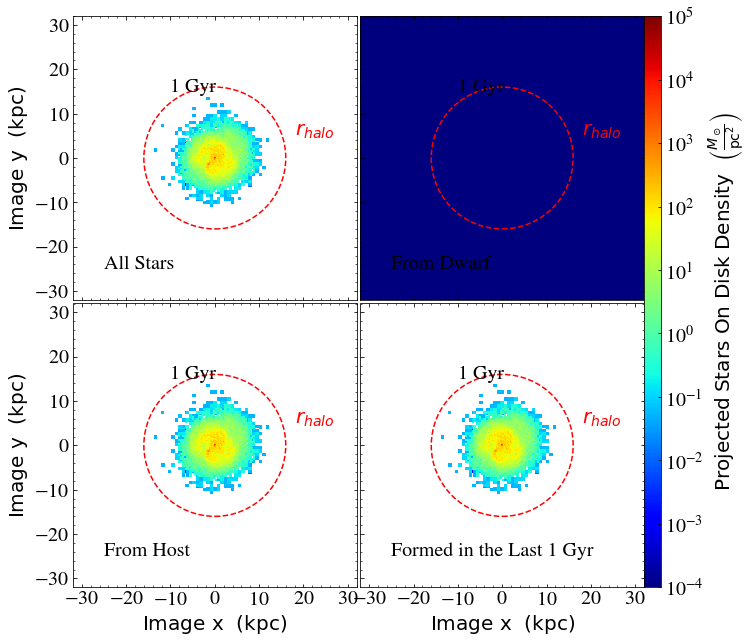

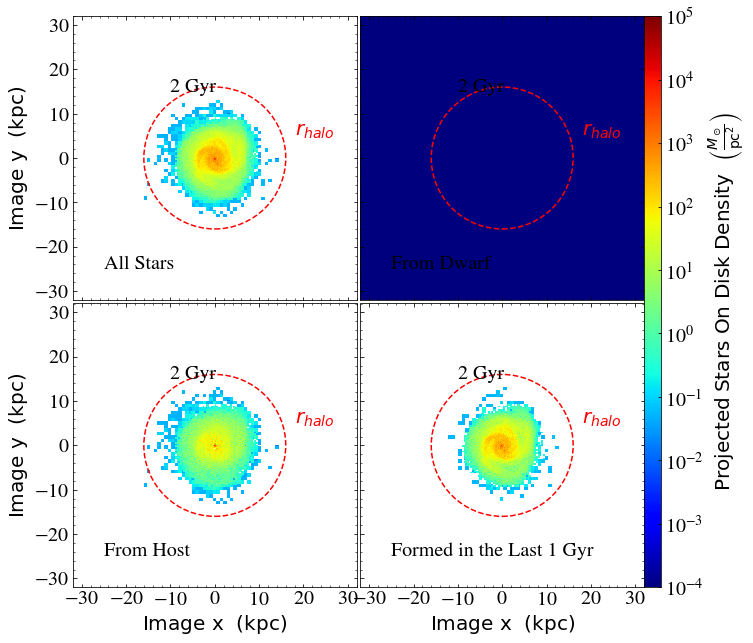

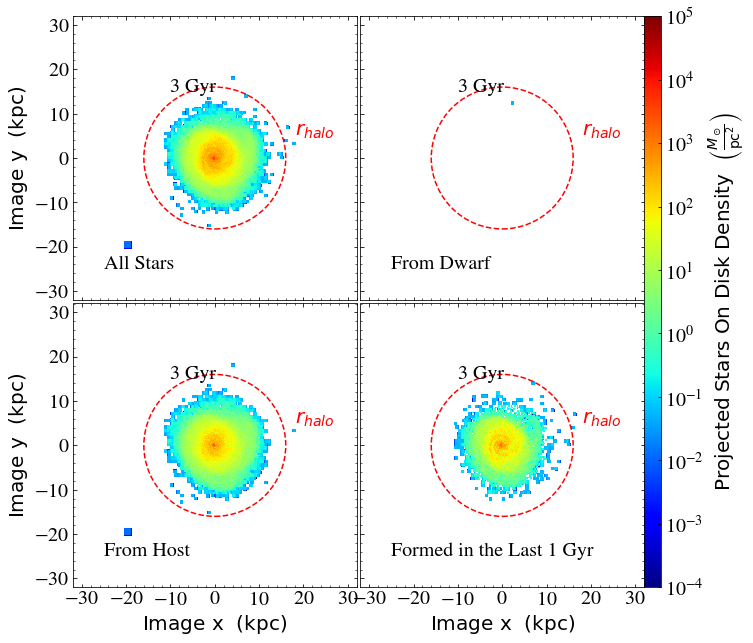

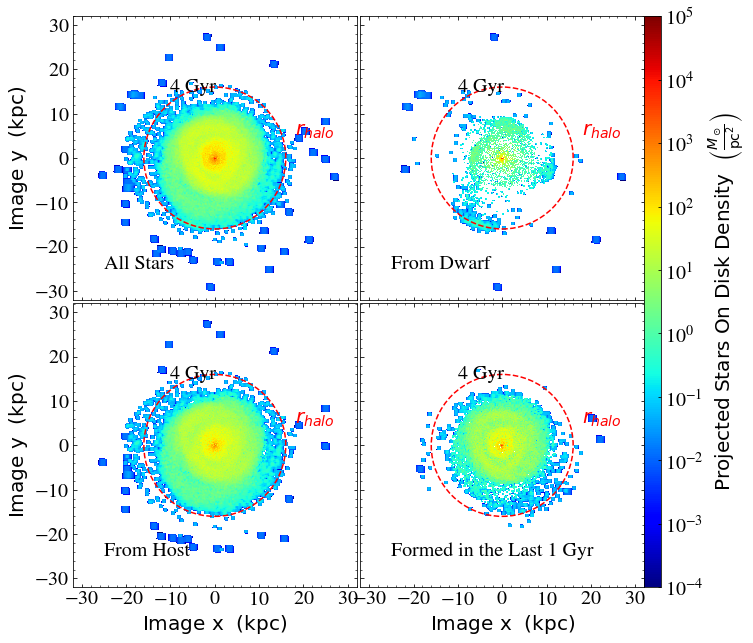

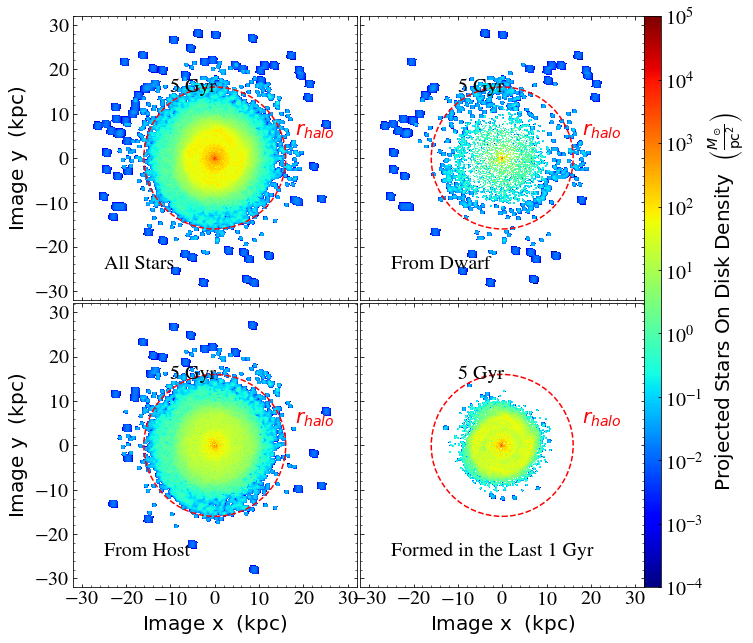

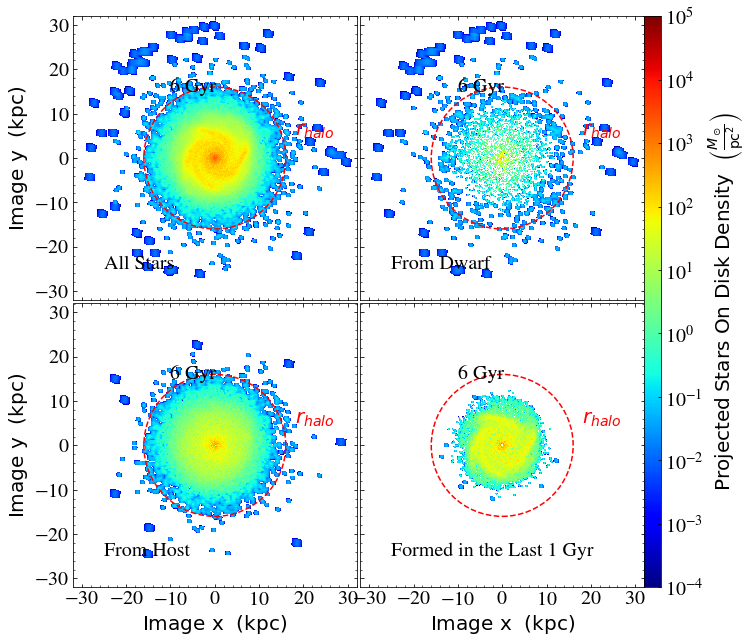

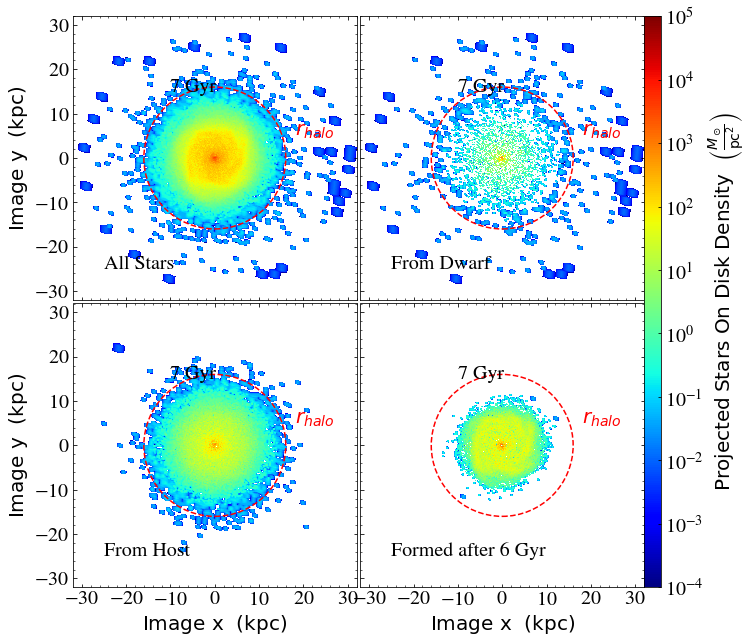

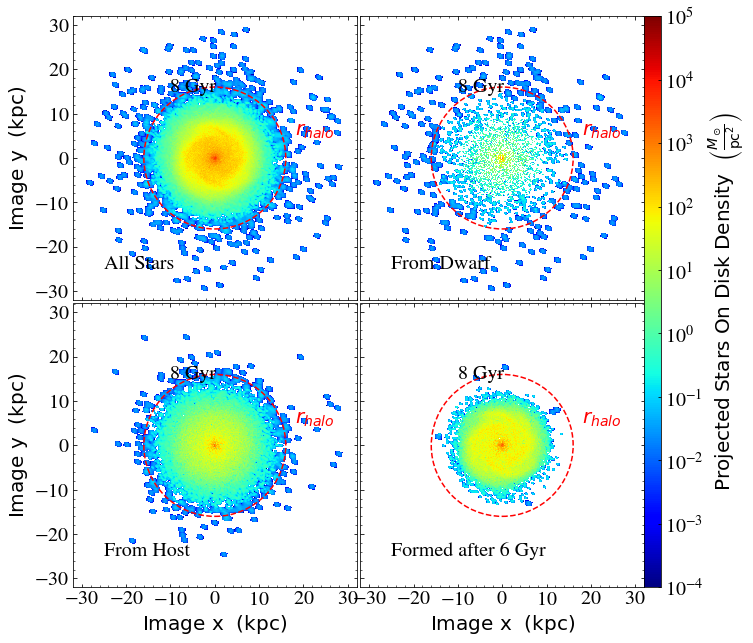

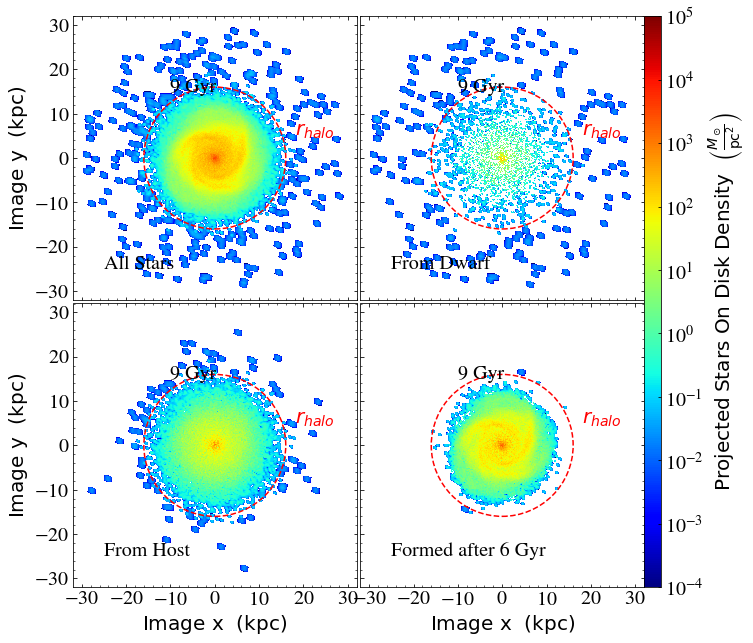

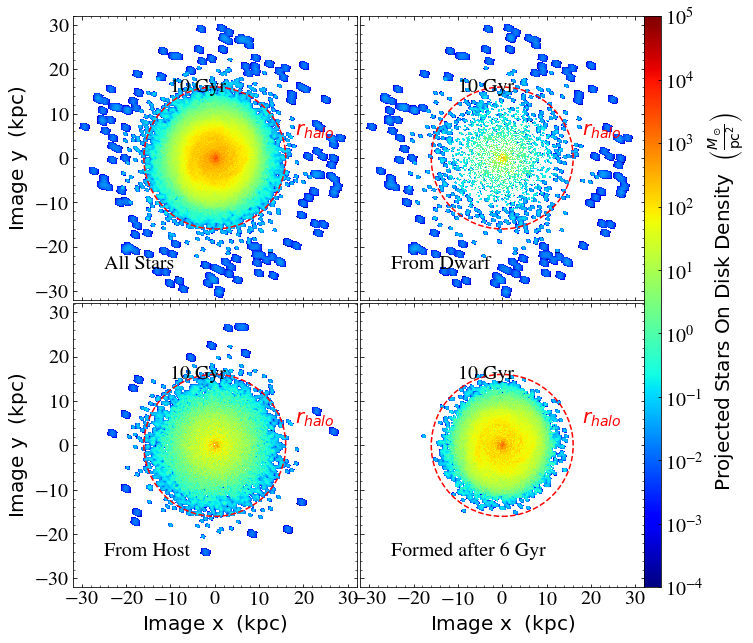

In [26]:
from mpl_toolkits.axes_grid1 import AxesGrid
for i in range(len(ds_array)):
    ds = ds_array[i]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height = 15*yt.units.kpc)
    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

    AM = -np.cross(
    host_galaxy['Stars', 'particle_position_relative'].in_units('kpc'),
    host_galaxy['Stars', 'particle_velocity_relative'].in_units('km/s'))\
    * yt.units.km * yt.units.kpc / yt.units.s

    cos = AM[:,2] / (np.linalg.norm(AM, axis=1) * yt.units.cm / yt.units.s)
    theta = np.arccos(cos) * 180 / C.pi

    index_theta_i = np.isin(ds.all_data()['Stars', 'iord'], host_galaxy['Stars', 'iord'][theta<15])
    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time) & index_theta_i
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[i-1].current_time) & index_theta_i
    if i==0:
        index_sf_i = index_host_i
    if (i<6) & (i>0):
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[i-1].current_time) & index_theta_i #index_sf[   :ds.particle_type_counts['Stars']]
    if i>5:
        index_sf_i    = index_sf[   :ds.particle_type_counts['Stars']] & index_theta_i

    ds.add_particle_filter('Stars_on_disk')
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_during_merger')

    fig = plt.figure()

    label = ['Stars_on_disk_density', 'Stars_from_dwarf_density',
            'Stars_from_host_density', 'Stars_during_merger_density']
    annot = ['All Stars', 'From Dwarf','From Host',
            'Formed in the Last 1 Gyr', 'Formed after 6 Gyr']
    # See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
    # These choices of keyword arguments produce a four panel plot with a single
    # shared narrow colorbar on the right hand side of the multipanel plot. Axes
    # labels are drawn for all plots since we're slicing along different directions
    # for each plot.
    grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                    nrows_ncols = (2, 2),
                    axes_pad = 0.05,
                    label_mode = "L",
                    share_all = True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="3%",
                    cbar_pad="0%")

    for jj in range(len(label)):
        pp_all_star = yt.OffAxisProjectionPlot(ds, norm_host, ('deposit', label[jj]),
                                                center=centerHost, width=4*r_3, depth=4*r_3,
                                                north_vector=north_host, method='integrate', fontsize=20)

        # Ensure the colorbar limits match for all plots
        pp_all_star.set_unit(('deposit', label[jj]), 'Msun/pc**2')
        pp_all_star.set_cmap(('deposit', label[jj]), 'jet')
        pos_of_annotate1 = yt.YTArray([-10, 15], input_units='kpc')
        pos_of_annotate2 = yt.YTArray([-25,-25], input_units='kpc')
        pos_of_annotate3 = yt.YTArray([ 18,  5], input_units='kpc')
        pp_all_star.annotate_clear()
        pp_all_star.annotate_text(pos_of_annotate1, '%d Gyr'%(i+1), coord_system='plot', text_args={'color':'black'})
        if (i<6) | (jj!=3):
            pp_all_star.annotate_text(pos_of_annotate2, annot[jj], coord_system='plot', text_args={'color':'black'})
        if (i>5) & (jj==3):
            pp_all_star.annotate_text(pos_of_annotate2, annot[4], coord_system='plot', text_args={'color':'black'})
        '''
        pp_all_star.annotate_line([0, 0.5 - t_height/(8*r_3)], [1, 0.5 - t_height/(8*r_3)], coord_system='axis',
                        plot_args={'color':'black', 'linestyle':'--', 'alpha':0.7})
        pp_all_star.annotate_line([0, 0.5 + t_height/(8*r_3)], [1, 0.5 + t_height/(8*r_3)], coord_system='axis',
                        plot_args={'color':'black', 'linestyle':'--', 'alpha':0.7})
        pp_all_star.annotate_line([0.25 , 0], [0.25, 1], coord_system='axis',
                        plot_args={'color':'red', 'linestyle':'--', 'alpha':1})
        pp_all_star.annotate_line([0.75 , 0], [0.75, 1], coord_system='axis',
                        plot_args={'color':'red', 'linestyle':'--', 'alpha':1})
        '''
        pp_all_star.annotate_sphere(centerHost, radius=r_3,
                          circle_args={'color':'red', 'linestyle':'--', 'linewidth':1.5})
        pp_all_star.annotate_text(pos_of_annotate3, '$r_{halo}$', coord_system='plot', text_args={'color':'red'})
        pp_all_star.set_zlim(('deposit', label[jj]), 1e-4, 1e5)

        # This forces the ProjectionPlot to redraw itself on the AxesGrid axes.
        plot = pp_all_star.plots[('deposit', label[jj])]
        plot.figure = fig
        plot.axes = grid[jj].axes
        plot.cax = grid.cbar_axes[jj]

        # Finally, this actually redraws the plot.
        pp_all_star._setup_plots()

    plt.savefig('figs/ProjectionPlots/multiplot_components_disk_15deg_'+str(i+1)+'_f.png',
                mpl_kwargs={'dpi':500, 'bbox_inches':'tight'});

In [34]:
?plt.legend

In [31]:
%store -r profiles

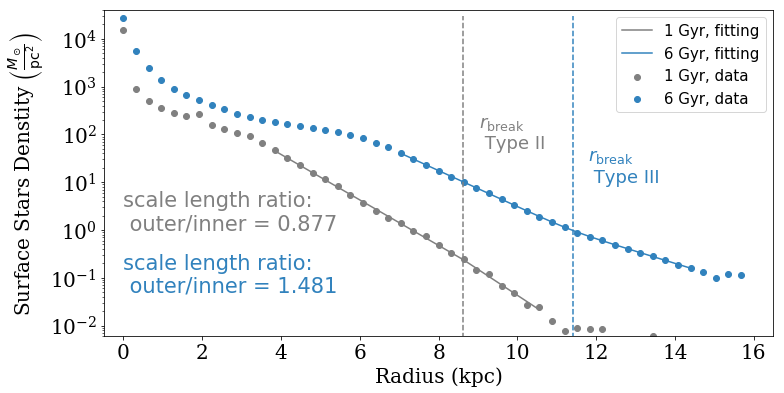

In [32]:
# density profile
plt.figure(figsize=(12, 6))
#for ii in range(6):
#    plt.plot(xaxis.in_units('kpc'),profiles[ii].in_units('Msun/pc**2'),
#             label=str(ii+1)+' Gyr')
plt.scatter(xaxis.in_units('kpc'),
            profiles[0].in_units('Msun/pc**2'),
            label=str(0 + 1) + ' Gyr, data',
            color='grey')
plt.plot(r_disc[(r_disc >= r_in0) & (r_disc <= r_out0)],
         I_show(np.array(r_disc[(r_disc >= r_in0) & (r_disc <= r_out0)]),
                res_robust0.x),
         label=str(0 + 1) + ' Gyr, fitting',
         color='grey')
plt.scatter(xaxis.in_units('kpc'),
            profiles[5].in_units('Msun/pc**2'),
            label=str(5 + 1) + ' Gyr, data',
            color='#3182bd')
plt.plot(r_disc[(r_disc >= r_in5) & (r_disc <= r_out5)],
         I_show(np.array(r_disc[(r_disc >= r_in5) & (r_disc <= r_out5)]),
                res_robust5.x),
         label=str(5 + 1) + ' Gyr, fitting',
         color='#3182bd')
plt.plot(np.ones(4) * r_break[0],
         np.arange(4) * 1e4,
         color='grey',
         linestyle="--")
plt.plot(np.ones(4) * r_break[5],
         np.arange(4) * 1e4,
         color='#3182bd',
         linestyle="--")
#plt.plot(np.ones(5)*r_break, np.arange(5)*2e3, color='black',linestyle="--", alpha=0.7)

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20,
           family='serif',
           weight='ultralight')
plt.xlabel('Radius (kpc)', fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
#plt.annotate('$r_1$', xy =( float(r_1)+1, 1e4), fontsize=15 )
plt.annotate('$r_\mathrm{break}$\n Type III',
             xy=(float(r_break[5]) + 0.4, 1e1),
             fontsize=18,
             color='#3182bd')
plt.annotate('$r_\mathrm{break}$\n Type II',
             xy=(float(r_break[0]) + 0.4, 5e1),
             fontsize=18,
             color='grey')
plt.annotate('scale length ratio: \n outer/inner = %.3f' % oiratio[0],
             xy=(0, 1e0),
             fontsize=21,
             color='grey')
plt.annotate('scale length ratio: \n outer/inner = %.3f' % oiratio[5],
             xy=(0, 5e-2),
             fontsize=21,
             color='#3182bd')

plt.xlim([-0.5, (r_3 + 0.5 * yt.units.kpc).base])
plt.ylim([6e-3, 4e4])
#plt.title(r'Density Profiles at Different Epoch',fontsize=20, family='serif', weight='ultralight')
plt.legend(fontsize=15)
plt.savefig('figs/694_profile_change.pdf', dpi=400)